In [1]:
import numpy as np
import rdkit.Chem.Descriptors as Descriptors
import rdkit.Chem.rdMolDescriptors as rdMolDescriptors
import rdkit.Chem.EState as EState
import rdkit.Chem.rdPartialCharges as rdPartialCharges
import rdkit.Chem.rdChemReactions as rdRxns
import rdkit.Chem.rdChemReactions as ReactionFromSmarts
import os
from rdkit.Chem import rdChemReactions
from chemical_module import Chemical
from reaction import Reaction
os.system('clear')
att_dtype = np.float32
import pandas as pd 
from rdkit import Chem  
from rdkit.Chem import rdMolDescriptors,Draw,AllChem 
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
import urllib.request
import requests
import os
import csv
from pprint import pprint
import re
import itertools
#import util 
from datapreprocessing import conversion, collecting_reactions_kegg, original_kegg_reactions, split_into_reactions_products
from type_conversion import smarts_to_smiles, circular_fingerprints, similarity_check, running_through_all_reaction_templates
from rdkit import DataStructs
from datapreprocessing import kegg_dictionary, reducing_reaction_rules
from datapreprocessing import mol_level_descriptors, atom_level_descriptors
from datapreprocessing import circular_fingerprint, encoding
from rdkit import RDLogger
from type_conversion import moltosmiles
RDLogger.DisableLog('rdApp.*')

RDKit WARNING: [14:13:32] Enabling RDKit 2019.09.3 jupyter extensions


this is working


In [4]:
kegg_reactions = pd.read_csv("ATLAS_Curated_KEGG_Reactions_ori.csv")
SMILE_rxn_rules = pd.read_csv("SMILE_reaction_rules.csv")

In [5]:
def training_data_reaction_features(REA,PRO):
    features = []
    from chemical_module import Chemical
    from reaction import Reaction
    from rdkit.Chem import rdChemReactions
    for i in range(0,len(REA)):
        try:
            reaction_smiles = ">>".join([PRO[i][0][0],REA[i]])
            individual_features = new_atomic_features(reaction_smiles)
            temp_features = np.concatenate([individual_features[0],individual_features[1]])
            #features.append([i,np.concatenate([temp_features[0:6],temp_features[7:13]])])
            features.append([i,temp_features])
        except (TypeError,IndexError):
            print(i)
    return features

def atomic(reactents,products):
    features = []
    from chemical_module import Chemical
    from reaction import Reaction
    from rdkit.Chem import rdChemReactions
    for i in range(0,len(reactents)):
        try:
            reaction_smiles = ">>".join([products[i][0][0],reactents[i]])
            #print("reaction smiels",reaction_smiles)
            rxn = Reaction(reaction_smiles, verbose=True)
            core = rxn.find_core()
            features.append([i,core])
        except :
            print(i)
    return features

def dictionary(df,df_dict=None):
    if df_dict:
        pass 
    else:
        df_dict = dict()
    for i in range(0,df.shape[0]):
        print(i)
        temp = df["Rule_Smarts"][i]
        if temp not in df_dict:
            df_dict[temp] = [df['Reaction_EC_number'][i]]
        if temp in df_dict:
            if df['Reaction_EC_number'][i] not in df_dict[temp]:
                df_dict[temp].append([df['Reaction_EC_number'][i]])
    return df_dict

def atomic_features_ran(cores):
    features = []
    from chemical_module import Chemical
    from reaction import Reaction
    from rdkit.Chem import rdChemReactions
    for i in range(0,len(cores)):
        try:
            individual_features = new_atomic_features(cores[i])
            temp_features = np.concatenate([individual_features[0],individual_features[1]])
            features.append([i,temp_features])
        except (TypeError,IndexError):
            print(i)
    return features

def circular_fingerprint(smile_string):
    mol = Chem.MolFromSmiles(smile_string)
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, bitInfo=bi)
    return fp.ToBitString()

def encoding(current_element):
    return [int(item) for item in circular_fingerprint(current_element)]

def making_product_reactents_morgan_fingerprints(a_a):
    merging_element_df = []
    temporary_merging_element = np.zeros((1,2048))
    for i in range(0,len(a_a)):
        for j in range(0,len(a_a[i])):
            item = a_a[i][j]
            if item != []:
                temporary_merging_element+=encoding(item[0])
            #print(len(merging_element_df))
            temporary_merging_element = np.zeros((1,2048))
        merging_element_df.append(temporary_merging_element)
    return merging_element_df

def classififes_negative_reaction():
    """
    This self contained function should be converting the kegg reactions smiles and using more then one product to create;
    this function would sort the list of products based on the length of the smile string. The first one would be classified as the 
    more important string classified as positive strings and others which are smaller in length strings would be classifies as negative 
    strings. There exist multiple null reactions in the datacase wich will also need to be removed.
    """
    temp = []
    for i in range(0,len(PRO)):
        current_length = len(PRO[i])
        if current_length >1:
            sorted_product = list(reversed(sorted(PRO[i], key=len)))
            for j in range(0,current_length):
                if sorted_product[j]:
                    if j == 0 :
                        item = sorted_product[j][0]
                        while type(item) != str:
                            if item != []:
                                item = item[0]
                        temp.append([REA[i][0],sorted_product[j][0],"Positive"])
                    else:
                        temp.append([REA[i][0],sorted_product[j][0],"Negative"])
                else:
                    pass 
        else:
            temp.append([REA[i],PRO[i],"Positive"])
    df = pd.DataFrame(temp)
    df.columns = ["Reactent","Product","Type"]
    return df

def product_fingerprints_function(PRO):
    product_fingerprints_chest = []
    for i in range(0,len(PRO)):
        item = PRO[i]
        while type(item) != str:
            if item != []:
                item = item[0]
        product_fingerprints_chest.append(encoding(item))
    return product_fingerprints_chest

def new_atomic_features(cores):
    """
    Input: Reaction in smarts format 
    Return type: array with 
    """
    product_addition = np.zeros((1,7))
    reactant_addition = np.zeros((1,7))  
    rea_nju = Chem.MolFromSmiles(cores.split(">>")[1])
    pro_nju = Chem.MolFromSmiles(cores.split(">>")[0])
    if pro_nju != None:
        pro_nju = Chem.AddHs(pro_nju,explicitOnly=True)
        pro_nju = atom_level_descriptors(pro_nju)
        for i in range(0,len(pro_nju[1])):
            product_addition = np.add(product_addition,pro_nju[1][i])
    if rea_nju != None:
        rea_nju = Chem.AddHs(rea_nju,explicitOnly=True)
        rea_nju = atom_level_descriptors(rea_nju)
        for j in range(0,len(rea_nju[1])):
            reactant_addition = np.add(reactant_addition,rea_nju[1][j])
     
    return np.concatenate([product_addition,reactant_addition])

def training_data_reaction_features(REA,PRO):
    features = []
    from chemical_module import Chemical
    from reaction import Reaction
    from rdkit.Chem import rdChemReactions
    for i in range(0,len(REA)):
        try:
            reaction_smiles = ">>".join([PRO[i][0][0],REA[i]])
            individual_features = new_atomic_features(reaction_smiles)
            temp_features = np.concatenate([individual_features[0],individual_features[1]])
            #features.append([i,np.concatenate([temp_features[0:6],temp_features[7:13]])])
            features.append([i,temp_features])
        except (TypeError,IndexError):
            print("Error in merging reactents and products",i)
    return features

def atomic(reactents,products):
    features = []
    from chemical_module import Chemical
    from reaction import Reaction
    from rdkit.Chem import rdChemReactions
    for i in range(0,len(reactents)):
        try:
            reaction_smiles = ">>".join([products[i][0][0],reactents[i]])
            #print("reaction smiels",reaction_smiles)
            rxn = Reaction(reaction_smiles, verbose=True)
            core = rxn.find_core()
            features.append([i,core])
        except :
            print("Deletion at stage of creating reaction smiles.",i)
    return features


def atomic_features_ran(cores):
    features = []
    from chemical_module import Chemical
    from reaction import Reaction
    from rdkit.Chem import rdChemReactions
    for i in range(0,len(cores)):
        try:
            individual_features = new_atomic_features(cores[i])
            temp_features = np.concatenate([individual_features[0],individual_features[1]])
            features.append([i,temp_features])
        except (TypeError,IndexError):
            print("Deletion at the atomic features running stage", i)
    return features

def get_hydrogen_atoms(my_mol):
    my_mol = Chem.MolFromSmiles(moltosmiles(my_mol))
    my_mol_with_explicit_h = Chem.AddHs(my_mol)
    return my_mol_with_explicit_h.GetNumAtoms() - my_mol_with_explicit_h.GetNumHeavyAtoms()

def reaction_hydrogen_removed(reaction):
    print("Current reaction is",reaction)
    product, reactent = reaction.split(">>")
    product = (product).replace("[H]","")
    #product =  product.replace("()","")
    reactent = (reactent).replace("[H]","")
    #reactent =  reactent.replace("()","")
    return ">>".join([product,reactent])

def runnning_reaction_hydrogen_removed(df):
    for i in range(0,df.shape[0]):
        df["Rule_SMARTS"][i] = reaction_hydrogen_removed(df["Rule_SMARTS"][i])
    return df


def generate_EC_numbers(j,e):
    my_rules = []
    rules_dict = list(j.keys())
    for i in range(0,len(rules_dict)):
        if i in e:
            my_rules.append(rules_dict[i])
    EC_numbers = []
    for i in range(0,len(my_rules)):
        EC_numbers.append(j[my_rules[i]])
    return EC_numbers

def only_smile(sorted_a):
    no_duplicates = []
    for i in range(0,len(sorted_a)):
        if sorted_a["Smiles"][i] not in no_duplicates:
            no_duplicates.append(sorted_a["Smiles"][i])
    return no_duplicates

def results_sorted(sorted_a,pattern,hydrogen_add):
    res = []
    patt = Chem.MolFromSmiles(pattern)
    if hydrogen_add == True:
        patt = Chem.AddHs(patt)
        for i in range(0,len(sorted_a)):
            ide = Chem.MolFromSmiles(sorted_a[i])
            ide = Chem.AddHs(ide)
            if patt.HasSubstructMatch(ide) and ide.HasSubstructMatch(patt):
                res.append(i)
    if hydrogen_add == False:
        for i in range(0,len(sorted_a)):
            ide = Chem.MolFromSmiles(sorted_a[i])
            if patt.HasSubstructMatch(ide) and ide.HasSubstructMatch(patt):
                res.append(i)
    return res[0]+1

def tanimoto(initial,all_products):
    similarity_inital = []
    from rdkit.Chem import MACCSkeys
    for i in range(0,len(all_products)):
        mols = Chem.MolFromSmiles(initial),Chem.MolFromSmiles(all_products[i])
        fps = [ MACCSkeys.GenMACCSKeys(x) for x in mols ]
        similarity_inital.append([Chem.MolToSmiles(mols[1]),round(DataStructs.TanimotoSimilarity(fps[0], fps[1]), 4)])
    return similarity_inital

def tanimoto_sorted(sorted_a,pattern):
    res = []
    patt = Chem.MolFromSmiles(pattern)
    for i in range(0,len(sorted_a)):
        ide = Chem.MolFromSmiles(sorted_a[i])
        if patt.HasSubstructMatch(ide) and ide.HasSubstructMatch(patt):
            res.append(i)
    return res[0]+1

def split_products(correct_version_all_possible,types):
    rule_product = []
    for i in range(0,len(correct_version_all_possible)):
        if types == "comma":
            split_product = correct_version_all_possible["products"][i].split(",")
            for j in range(0,len(split_product)):
                rule_product.append([correct_version_all_possible["rulenumber"][i],split_product[j]])
        if types == "dot":
            split_product = correct_version_all_possible["products"][i].split(".")
            for j in range(0,len(split_product)):
                rule_product.append([correct_version_all_possible["rulenumber"][i],split_product[j]])
    return rule_product

def state_space_generation(molefile,unique_strings,hydrogen_add=True):
    item = []
    indexes = []
    rules = []
    from rdkit.Chem import rdChemReactions
    for i in range(0,len(unique_strings)):
        try:
            rxn = rdChemReactions.ReactionFromSmarts(unique_strings[i])
            if hydrogen_add == True:
                reacts = Chem.AddHs(Chem.MolFromSmiles(molefile))
            if hydrogen_add == False:
                reacts = Chem.MolFromSmiles(molefile)
            products = rxn.RunReactants((reacts,))
            for j in range(0,len(products)):
                try:
                    if products != (): 
                        Chem.SanitizeMol(products[j][0])
                        temp = Chem.AddHs(products[j][0])
                        item.append([i,Chem.MolToSmiles(temp)])
                except:
                    pass
        except:
            pass
    if len(item)<1:
        #print("No possible state generated increase rule size, f= state_space_generation")
        return []
    else:
        reactions = pd.DataFrame(item)
        reactions.columns = ["rulenumber","products"]
        return reactions


#Do Not touch this block
def searching_state_space_for_desired_product(possible_reactants,pattern):
    reactions = pd.DataFrame(possible_reactants)
    reactions.columns = ["rules","products"]
    found_it = []
    positions = []
    reaction_rules_iterator = []
    correct_rules = []
    for i in range(0,reactions.shape[0]):
        m = Chem.MolFromSmiles(pattern)
        m = Chem.AddHs(m)
        patt = Chem.MolFromSmiles(reactions["products"][i][0])
        try:
            patt = Chem.AddHs(patt)
            if patt.HasSubstructMatch(m) and m.HasSubstructMatch(patt):
                found_it.append(patt)
                reaction_rules_iterator.append(reactions["rules"][i])
                positions.append(i)
                correct_rules.append(reactions["rules"][i])
            else:
                reaction_rules_iterator.append(reactions["rules"][i])
        except AttributeError:
            pass 
    return found_it, positions, reaction_rules_iterator,correct_rules

In [61]:
def final_main(initial,target,rule_size,threshold=0.1,types = "molecular",hydrogen_add=True):
    correct_version_all_possible = state_space_generation(initial,rule_size,hydrogen_add)
    totalParts = []
    for i in range(0,len(correct_version_all_possible)):
        subparts = (correct_version_all_possible["products"])[i].split(".")
        for j in range(0,len(subparts)):
            totalParts.append([correct_version_all_possible["rulenumber"][i],subparts])
    correct_version_all_possible = pd.DataFrame(totalParts,columns = ["rulenumber","products"])
    found_it, positions, reaction_rules_iterator,correct_rules = searching_state_space_for_desired_product(correct_version_all_possible,target)
    if len(positions)>0:
        print("There are",len(positions),"Molecules matching target.")
        percentages = []
        for i in range(0,len(correct_version_all_possible)):
            mol_react = Chem.MolFromSmiles(correct_version_all_possible["products"][i][0])
            #mol_react = Chem.MolFromSmiles(correct_version_all_possible["products"][i])
            Chem.SanitizeMol(mol_react)
            react = Chem.MolToSmiles(Chem.AddHs(mol_react))
            #mol_react = mol_react 
            if types == "reaction":
                input_vec = np.array(encoding(react)).reshape(1,2048)
                res = rxn_model.predict(input_vec)
                #percentages.append([int(i),res[0][0],correct_version_all_possible["products"][i][0]]) 
                percentages.append([int(i),res[0][0],react]) 
            if types == "molecular":
                input_vec = np.array(encoding(react)).reshape(1,2048)
                merged_reaction = ">>".join([correct_version_all_possible["products"][i][0],initial])
                individual_features = new_atomic_features(merged_reaction)
                temp_features = np.concatenate([individual_features[0],individual_features[1]])
                input_vec = np.concatenate([input_vec[0],temp_features]).reshape(1,2062)
                res = molecule_model.predict(input_vec)
                #percentages.append([int(i),res[0][0],correct_version_all_possible["products"][i][0]])
                percentages.append([int(i),res[0][0],react]) 
            if types == "atomic_spectator":
                input_vec = np.array(encoding(react)).reshape(1,2048)
                merged_reaction = ">>".join([correct_version_all_possible["products"][i][0],initial])
                individual_features = new_atomic_features(merged_reaction)
                molecular_features = np.concatenate([individual_features[0],individual_features[1]])
                rxn = Reaction(merged_reaction, verbose=False)
                core = rxn.find_core()
                atomic_features =new_atomic_features(core)
                atomic_features_np = np.concatenate([atomic_features[0],atomic_features[1]])
                spectator = np.subtract(np.array(molecular_features),np.array(atomic_features_np))
                spectator = spectator.reshape(1,14)
                molecular_features = molecular_features.reshape(1,14)
                atomic_features_np = atomic_features_np.reshape(1,14)
                #cobined = np.concatenate([molecular_features,atomic_features_np])
                #cobined = np.concatenate([cobined,spectator]).reshape(1,42)
                cobined = np.concatenate([atomic_features_np,spectator]).reshape(1,28)
                just_reaction = np.array(input_vec[0])
                #input_vec = np.concatenate([just_reaction,cobined[0]]).reshape(1,2090)
                input_vec = np.concatenate([just_reaction,cobined[0]]).reshape(1,2076)
                input_vec = pd.DataFrame(input_vec,columns = np.arange(0,2076))
                #input_vec = pd.DataFrame(input_vec,columns = np.arange(0,2090))
                res = atomic_model_spec.predict(input_vec)
                percentages.append([int(i),res[0][0],correct_version_all_possible["products"][i][0]])
            if types == "atomic":
                input_vec = np.array(encoding(react)).reshape(1,2048)
                merged_reaction = ">>".join([correct_version_all_possible["products"][i][0],initial])
                #print(merged_reaction)
                individual_features = new_atomic_features(merged_reaction)
                #molecular_features = np.concatenate([individual_features[0],individual_features[1]])
                rxn = Reaction(merged_reaction, verbose=False)
                core = rxn.find_core()
                atomic_features =new_atomic_features(core)
                atomic_features_np = np.concatenate([atomic_features[0],atomic_features[1]])
                #cobined = np.concatenate([molecular_features,atomic_features_np])
                cobined = atomic_features_np
                input_vec = np.concatenate([input_vec[0],cobined]).reshape(1,2062)
                input_vec = pd.DataFrame(input_vec,columns = np.arange(0,2062))
                res = atomic_model.predict(input_vec)
                #percentages.append([int(i),res[0][0],correct_version_all_possible["products"][i][0]])
                percentages.append([int(i),res[0][0],react])
        product_accuracy_values = pd.DataFrame(percentages)
        #print(product_accuracy_values)
        #print("length of actual and predicted",len(correct_version_all_possible),len(product_accuracy_values))
        product_accuracy_values.columns = ["product_index","Accuracy","Smiles"]
        product_accuracy_values.sort_values(by="Accuracy",ascending = False,inplace=True)
        sorted_a = product_accuracy_values.reset_index(drop=True)
        for i in range(0,sorted_a.shape[0]):
            sorted_a["product_index"][i] = int(sorted_a["product_index"][i])
        res = []
        #print("Positions are",positions)
        de_duplicated_smiles = only_smile(sorted_a)
        #threshold = 0.5
        #return (product_accuracy_values)
        try:
            df_similarity_inital = pd.DataFrame(tanimoto(initial,de_duplicated_smiles),columns = ["Products","Similarity"])
            tanimoto_filtering = df_similarity_inital[df_similarity_inital["Similarity"]>threshold]
            de_duplicated_smiles = list(tanimoto_filtering["Products"])
            #print("Total products are",len(correct_version_all_possible))
            #return (de_duplicated_smiles)
            print("The sorted rank after filtering is",results_sorted(de_duplicated_smiles,target,hydrogen_add),"out of",len(df_similarity_inital))
            #print(tanimoto_filtering)
            return df_similarity_inital,product_accuracy_values
        except IndexError:
            if len(positions)> 0:
                print("Increase threshold value")
            else:
                print("Error")
    else:
        print("No molecule matching please increase rule size")


In [7]:
REA, PRO = original_kegg_reactions(kegg_reactions,converting_dictionary=kegg_dictionary)
a  = making_product_reactents_morgan_fingerprints(REA)
reactent_fingerprints = pd.DataFrame([item[0] for item in a])
df = classififes_negative_reaction()
new = df[df["Type"]=="Positive"]
#new = df
new.reset_index(inplace = True)
new_REA,PRO = new["Reactent"],new["Product"]
new_products = np.array(PRO)
b = product_fingerprints_function(new_products)
product_fingerprints = pd.DataFrame([item[0] for item in b])
reaction_fingerprints = np.add(reactent_fingerprints,product_fingerprints)

In [8]:
all_values = []
current_max = []
for i in range(0,len(REA)):
    for item in REA[i]:
        if item != []:
            temp = get_hydrogen_atoms(item[0])
        current_max.append(temp)
    all_values.append(max(current_max))
    
Y = pd.DataFrame(all_values)
Y.columns = ["Y"]
#reduced_y = pd.merge(Y.reset_index(),indexes,on = "index",how = "inner")
from sklearn.preprocessing import MinMaxScaler
#y=np.reshape(reduced_y["Y"].values, (-1,1))
y=np.reshape(Y.values, (-1,1))
scaler_y = MinMaxScaler()
scaler_y.fit(y)
reduced_y=scaler_y.transform(y)

In [9]:
reduced_reactent_values = []
for i in range(0,len(REA)):
    val = [item[0] for item in [item for item in REA if item != []][i] if item != []]
    reduced_reactent_values.append(".".join(val))
    
new_prod = []
for i in range(0,len(new_products)):
    item = new_products[i]
    while type(item) != str:
        item = item[0]
    new_prod.append(item)

In [10]:
molecular = training_data_reaction_features(reduced_reactent_values,new_prod)
molecular_df = pd.DataFrame(molecular,columns = ["index","values"])
molecular_df_features = pd.DataFrame([item for item in molecular_df["values"]])
molecular_df_features["index"] = molecular_df["index"]
index = reaction_fingerprints.reset_index(inplace=False)
complete_X = pd.merge(index,molecular_df_features,how = "inner",on ="index")
Y = pd.DataFrame(reduced_y).reset_index(inplace=False)
complete_Y = pd.merge(complete_X["index"],Y,how = "inner",on ="index")
complete_X.drop(columns =["index"],inplace=True)
complete_Y.drop(columns =["index"],inplace=True)
complete_X = complete_X.replace([np.inf, -np.inf], [1000,-1000])

Error in merging reactents and products 1573
Error in merging reactents and products 1574


In [11]:
#REACTION LEVEL MODEL 
from keras.models import Sequential
from keras.layers import Dense, Dropout
rxn_input = index.drop(columns=["index"],inplace=False)
rxn_model = Sequential()
rxn_model.add(Dense(5, input_dim=rxn_input.shape[1], activation='tanh'))
rxn_model.add(Dropout(0.5, input_shape=(rxn_input.shape[1],)))
rxn_model.add(Dense(1, activation='sigmoid'))
rxn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = rxn_model.fit(rxn_input,reduced_y, epochs=15, batch_size=500,verbose=1,validation_data=(rxn_input.values,reduced_y), shuffle=True)

Using TensorFlow backend.


Train on 6651 samples, validate on 6651 samples
Epoch 1/15
6651/6651 [==============================] - 1s 139us/step - loss: 0.6769 - accuracy: 0.0200 - val_loss: 0.6536 - val_accuracy: 0.0262
Epoch 2/15
6651/6651 [==============================] - 1s 115us/step - loss: 0.6542 - accuracy: 0.0262 - val_loss: 0.6435 - val_accuracy: 0.0262
Epoch 3/15
6651/6651 [==============================] - 1s 98us/step - loss: 0.6497 - accuracy: 0.0262 - val_loss: 0.6392 - val_accuracy: 0.0262
Epoch 4/15
6651/6651 [==============================] - 1s 102us/step - loss: 0.6461 - accuracy: 0.0262 - val_loss: 0.6360 - val_accuracy: 0.0262
Epoch 5/15
6651/6651 [==============================] - 1s 122us/step - loss: 0.6403 - accuracy: 0.0262 - val_loss: 0.6330 - val_accuracy: 0.0262
Epoch 6/15
6651/6651 [==============================] - 1s 117us/step - loss: 0.6375 - accuracy: 0.0262 - val_loss: 0.6295 - val_accuracy: 0.0262
Epoch 7/15
6651/6651 [==============================] - 1s 152us/step - loss:

In [12]:
#MOLECULAR LEVEL MODEL
from keras.models import Sequential
from keras.layers import Dense, Dropout

molecule_model = Sequential()
molecule_model.add(Dense(5, input_dim=complete_X.shape[1], activation='tanh'))
molecule_model.add(Dropout(0.5, input_shape=(complete_X.shape[1],)))
molecule_model.add(Dense(1, activation='sigmoid'))
molecule_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = molecule_model.fit(complete_X,complete_Y, epochs=15, batch_size=500,verbose=1,
                 validation_data=(complete_X.values,complete_Y.values), shuffle=True)

Train on 6649 samples, validate on 6649 samples
Epoch 1/15
6649/6649 [==============================] - 1s 167us/step - loss: 0.8078 - accuracy: 0.0153 - val_loss: 0.6661 - val_accuracy: 0.0259
Epoch 2/15
6649/6649 [==============================] - 0s 61us/step - loss: 0.7709 - accuracy: 0.0183 - val_loss: 0.6473 - val_accuracy: 0.0262
Epoch 3/15
6649/6649 [==============================] - 0s 62us/step - loss: 0.7040 - accuracy: 0.0206 - val_loss: 0.6236 - val_accuracy: 0.0256
Epoch 4/15
6649/6649 [==============================] - 0s 61us/step - loss: 0.6733 - accuracy: 0.0215 - val_loss: 0.6094 - val_accuracy: 0.0262
Epoch 5/15
6649/6649 [==============================] - 0s 61us/step - loss: 0.6615 - accuracy: 0.0226 - val_loss: 0.6076 - val_accuracy: 0.0259
Epoch 6/15
6649/6649 [==============================] - 0s 61us/step - loss: 0.6560 - accuracy: 0.0212 - val_loss: 0.6083 - val_accuracy: 0.0263
Epoch 7/15
6649/6649 [==============================] - 0s 64us/step - loss: 0.65

In [13]:
aaa = atomic(reduced_reactent_values,PRO)
cores = pd.DataFrame(aaa,columns=["index","cores"])
atomic_y = pd.DataFrame(reduced_y)
atomic_y["index"] = np.arange(0,atomic_y.shape[0])
atomic_y = pd.merge(atomic_y,pd.DataFrame(molecular_df_features["index"]),how= "inner",on="index")
atomic_y.reset_index(inplace = True)
atomic_y = atomic_y.drop(columns = ["index","level_0"])
gvb = atomic_features_ran(list(cores["cores"]))
atomic_cores_ = pd.DataFrame(gvb,columns = ["index","values"])
atom_features_df = pd.DataFrame([item for item in atomic_cores_["values"]])

O=P(O)(O)O
O.O=P(O)(O)OP(=O)(O)O
O
O.NC(=O)NC(=O)O
CC(=O)C(=O)O
O=C=O.CC(=O)C(C)(O)C(=O)O
CC(=O)C(=O)O
CC(O)(CC(=O)C(=O)O)C(=O)O
O
OO
OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O
O.OC[C@H]1O[C@H](O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O
N
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
O
O=CC(=O)O
C
CC(=O)C(=O)O.Cc1ncc(C[n+]2csc(CCOP(=O)(O)OP(=O)(O)O)c2C)c(N)n1
O
OC[C@H]1O[C@H](O[C@]2(CO)O[C@H](CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O
N
NCCCCN
CC(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O)[C@@H]1O
O.CC(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2NC(C)=O)[C@@H]1O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1
OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O
O.OC[C@H]1O[C@@H](O[C@@H]2[C@@H](CO)OC(O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O
O=Cc1ccccc1
O=C(c1ccccc1)C(O)c1ccccc1
OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O
O.OC[C@H]1O[C@H](O[C@

C
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C[C@](C)(O)C(=O)O
C
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CCC(=O)O)C(=O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CCC(=O)O)C(=O)O
[
Deletion at stage of creating reaction smiles. 139
[
Deletion at stage of creating reaction smiles. 140
[
Deletion at stage of creating reaction smiles. 141
O
O.O=O.N[C@@H](CCC(=O)O)C(=O)O
N
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C1CC[C@@H](C(=O)O)N1
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N.N[C@@H](CCC(=O)O)C(=O)O
N
O=C=O.N.N[C@@H](CCC(=O)O)C(=O)O
N
O.NC(=O)CC[C@H](N)C(=O)O
N
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.NC(=O)CC[

N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
C
CC(=O)C(=O)O.Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
C
O=C(O)CC(=O)C(=O)O.Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
C
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.O=C(O)CCC(=O)O.Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
N
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
O=P(O)(O)OP(=O)(O)O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
O=P(O)(O)O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
O=P(O)(O)O
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
O=P(O)(O

N
Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)n1
N
O.NC(=O)CC[C@H](N)C(=O)O.O=C([O-])O
N
CC(=O)C(=O)O.NC(=O)CC[C@H](N)C(=O)O
*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.NC(=O)CC[C@H](N)C(=O)O
N
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CC(=O)O)C(=O)O.NC(=O)CC[C@H](N)C(=O)O
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C@@H](CO)C(=O)O
N
O.N[C@@H](COP(=O)(O)O)C(=O)O
N
O=P(O)(O)OP(=O)(O)O.N[C@@H](CO)C(=O)O
O
CC(=O)C(=O)O.N[C@@H](CO)C(=O)O
C
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.N[C@@H](CO)C(=O)O
O
O=CC(=O)O.N[C@@H](CO)C(=O)O
C
N[C@@H](CO)C(=O)O
*
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.*[C@@H]1O[C@H](COP(=O)(O)O[C@@H]2[C@@H](COP(=O)(O)O[C@H]3[C@@H](O)[C@H](

NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C@@H](CC1(C(=O)O)C=CC(O)C=C1)C(=O)O
N
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C@@H](CC1(C(=O)O)C=CC(O)C=C1)C(=O)O
O
O=C(O)CCC(=O)C(=O)O.N[C@@H](Cc1ccc(O)cc1)C(=O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N=C(N)NCCC[C@H](N)C(=O)O.N[C@@H](Cc1ccc(O)cc1)C(=O)O
N
N[C@@H](Cc1ccc(O)cc1)C(=O)O
O
N[C@@H](Cc1ccc(O)cc1)C(=O)O
NC(CC(=O)O)c1ccc(O)cc1
N[C@@H](Cc1ccc(O)cc1)C(=O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.O=CCC(=O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(

N
O.N[C@@H](CS)C(=O)NCC(=O)O
N
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O.N[C@@H](CS)C(=O)O
N
O=S(O)O.N[C@@H](CS)C(=O)O
N
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.NCCC=O
N
O.NC(=O)NCCC(=O)O
N
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[C@@H](NCCC(=O)O)C(=O)O
N
C[C@H](N)C(=O)O.O=CCC(=O)O
O
O=C(O)CCC(=O)C(=O)O.NCCC(=O)O
N
O.CC(=O)NCCC(=O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.NCCCC[C@H](N)C(=O)O.NCCC(=O)O
N
O.NCCCC[C@H](NC(=O)CCN)C(=O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N=C(N)NCCC[C@H](N)C(=O)O.NCCC(=O)O
N
O.N=C(N)NCCC(=O)O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)

C
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CCC(C)CCOP(=O)(O)O
C
O.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CCC(C)CCOP(=O)(O)O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
C
CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CCC(C)CCOP(=O)(O)O
C
CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CCC(C)CCOP(=O)(O)O
C
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CCC(C)CCOP(=O)(O)O
O
O.O=C(CO)COP(=O)(O)O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C(CO)CO
O
C=C(OP(=O)(O)O)C(=O)O.O=C(CO)CO
*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[

C
O=P(O)(O)O.CCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)c2cc1C.CCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.CCCC(=O)O
C
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.CCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
CC(=O)O.CCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc

C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.CCCCCCCCCCCCCCCC(=O)O
C
N[C@@H](CO)C(=O)O.CCCCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
S
O.N[C@@H](CCS)C(=O)O
N
O.N[C@@H](CCSC[C@H](N)C(=O)O)C(=O)O
N
S.CC(=O)OCC[C@H](N)C(=O)O
N
S.N[C@@H](CCOC(=O)CCC(=O)O)C(=O)O
N
N[C@@H](CO)C(=O)O.N[C@@H](CCS)C(=O)O
N
N[C@@H](CO)C(=O)O.N[C@@H](CCS)C(=O)O
N
N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O.N[C@@H](CCSSCC[C@H](N)C(=O)O)C(=O)O
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=Cc1ccc(O)cc1
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=Cc1ccc(O)cc1
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cn

C
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)[C@H](N)C(=O)O
C
CC(C)[C@H](N)C(=O)O
O
C=O.O=C(CO)[C@@H](O)[C@H](O)COP(=O)(O)O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.OC[C@H]1O[C@@H](O[C@@H]2[C@@H](CO)OC(O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O
O
O=O.OC[C@H]1O[C@@H](O[C@@H]2[C@@H](CO)OC(O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O
O
O.OC[C@H]1O[C@@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@@H]3[C@@H](CO)OC(O)[C@H](O)[C@H]3O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O
C
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[C@H](O)C=O
O
O=C(O)CC(=O)C(=O)O.C[C@H](O)C(=O)O
C
O.C[C@@H](OS(=O)(=O)O)C(=O)O
C
CCC(=O)O.CC(O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C

O
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O
O
O=P(O)(O)O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O
N
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](OP(=O)(O)O)[C@H]1O
C
O.CN(CC(=O)O)C(N)=O
C
O.O=O.CN(C)CC(=O)O
C
O.CN(CC(=O)O)C(=N)N
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O
C
O.Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)O)O2)c(=O)[nH]c1=O
O
O=P(O)(O)O.Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]1O.Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.OC1OC[C@@H](O)[C@@H](O)[C@@H]1O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OC1OC[C@@H](O)[C@@H](O)[C@@H]1O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@

O
O=C(O)CC(=O)C(=O)O.N[C@@H](CC1(C(=O)O)C=CC(O)C=C1)C(=O)O
C
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[C@@H](O)C=O
C
O.C[C@@H](O)C(=O)SC[C@H](NC(=O)CC[C@H](N)C(=O)O)C(=O)NCC(=O)O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H

S
O.N[C@H](CS)C(=O)O
O
O=P(O)(O)O.O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1
O
O.O=c1ccn([C@@H]2O[C@H](CO)[C@@H](OP(=O)(O)O)[C@H]2O)c(=O)[nH]1
O
O.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1
O
O=O.O=C(O)CCC(=O)C(=O)O.O=c1ccn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]1
N
Nc1nc2c(ncn2[C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O2)c(=O)[nH]1.O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CN(CC(=O)O)C(=N)N
C
O.CN(CC(=O)O)C(=N)NP(=O)(O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.N=C(N)NCC(=O)O
CN(CC(=O)O)C(=N)N
O.CN1CC(=O)NC1=N
O
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](O)[C@H](O)[C@@H]2O)[C@@H](O)[C@H]1O
N
O.N=C(NCCC[C@H](N)C(=O)O)N[C@H]1O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3cnc4c(N)ncnc43)[C@H](O)[C@@H]2O)[C@@H](O)[C@H]1O
N
O.N#CC(N)CCC(=O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.NC[C@H]1

*
O.*N[C@H]1CSSC[C@@H](C(*)=O)NC(=O)[C@H](*)NC(=O)[C@H](*)NC1=O.Nc1ccn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O)O2)c(=O)n1
C
O.CSCC[C@H](N)C(=O)O.*N[C@H]1CSSC[C@@H](C(*)=O)NC(=O)[C@H](*)NC(=O)[C@H](*)NC1=O
*
O.*C(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)OC(*)=O
*
O.*C(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)COP(=O)(O)O)OC(*)=O
*
*C(=O)OC[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O)OC(*)=O.*C(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)OC(*)=O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)COP(=O)(O)O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)COP(=O)(O)O
O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)COP(=O)(O)O
O.O=C1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H](O)[C@H]1O
O
O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)COP(=O)(O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@

O=C(O)[C@H](O)COP(=O)(O)O
O=C(OP(=O)(O)O)[C@H](O)COP(=O)(O)O
*
O.*[C@@H](NC(N)=O)C(=O)O
*
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.*[C@@H](N)C(=O)O
*
O.*C(=O)N[C@H](*)C(=O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.COc1cc(/C=C/C=O)ccc1O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.COc1cc(/C=C/C(=O)O)ccc1O
C
O=C(O)[C@]1(O)C[C@@H](O)[C@@H](O)[C@H](O)C1.COc1cc(/C=C/C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3cnc4c(N)ncnc43)[C@H](O)[C@@H]2OP(=O)(O)O)ccc1O
C
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C

CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)C[C@@H]2O/C(=C\CCCC(=O)O)C[C@@H]21
CCCCC[C@H](O)/C=C/[C@H]1[C@H]2C[C@H](OO2)[C@@H]1C/C=C\CCCC(=O)O
CCCCC[C@H](O)/C=C/[C@H]1O[C@H]2C[C@H](O2)[C@@H]1C/C=C\CCCC(=O)O
CCCCC[C@H](O)/C=C/[C@H]1[C@H]2C[C@H](OO2)[C@@H]1C/C=C\CCCC(=O)O
NC(=O)NCCC(=O)O
O.O=C1CCNC(=O)N1
O
CC(=O)C(=O)O.NCC(=O)CCC(=O)O
N[C@H](C=O)CCC(=O)O
NCC(=O)CCC(=O)O
N
O.NCCCCC(N)=O
O
O=C(O)CCC(=O)C(=O)O.NCCCCC(=O)O
N
O.CC(=O)NCCCCC(=O)O
*
O=O.*C(*)O
C
N[C@@H](CCC(=O)O)C(=O)O.CC(=O)N[C@@H](CCCN)C(=O)O
C
O=C(O)CCC(=O)C(=O)O.CC(=O)N[C@@H](CCCN)C(=O)O
NC(=O)N[C@@H](CC(=O)O)C(=O)O
O.O=C(O)C[C@@H]1NC(=O)NC1=O
N
O.N=CN[C@@H](CCC(=O)O)C(=O)O
O
O.N=CN[C@@H](CCC(=O)O)C(=O)O
N
N[C@@H](CCC(=O)O)C(=O)O.N=CN1c2c(nc(N)[nH]c2=O)NC[C@@H]1CNc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1
N=CN[C@@H](CCC(=O)O)C(=O)O
O.O=C(O)CCC1NC=NC1=O
N
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=P(O)(O)O.N[C@@H](CC=O)C(=O)O
N
CC(=O)C(=O)O.NCC[C@H](N)C(=

O
O=C(O)C[C@@H](O)C(=O)O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@H]1O
N
O.NC(=O)NC(NC(N)=O)C(=O)O
N
O.NC(=O)NC(NC(N)=O)C(=O)O
NC(=O)NC(NC(N)=O)C(=O)O
O.NC(=O)N[C@H]1NC(=O)NC1=O
C
Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)n1
O=C(O)[C@H](O)[C@@H](O)[C@H](O)CO
O.O=C1OC[C@@H](O)[C@H](O)[C@H]1O
O=C(O)[C@H](O)[C@@H](O)[C@H](O)CO
O.O=C1O[C@H](CO)[C@H](O)[C@H]1O
O
O=C(O)[C@H](O)[C@@H](O)[C@H](O)CO
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.OC[C@H](O)[C@H](O)CO
O
O=C(O)CCC(=O)C(=O)O.N[C@@H](CS(=O)(=O)O)C(=O)O
N
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].N[C@@H](CS(=O)(=O)O)C(=O)O
C
O.C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)cc(O)c3c2=O)[C@H](O)[C@H](O)[C@H]1O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(

O
O.NC(=O)Cc1ccccc1
C
O.*C(=O)N[C@@H](COP(=O)(O)OCC[N+](C)(C)C)[C@H](O)/C=C/CCCCCCCCCCCCC
*
O.*C(=O)N[C@@H](COP(=O)(O)OCC[N+](C)(C)C)[C@H](O)/C=C/CCCCCCCCCCCCC
*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.CCCCCCCCCCCCC/C=C/[C@@H](O)[C@@H](N)COP(=O)(O)OCC[N+](C)(C)C
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@@H](O)[C@@H](O)C(=O)O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@@H](O)[C@@H](O)C(=O)O
O=C(O)[C@@H](O)[C@@H](O)C(=O)O
O.O=C(O)[C@@H]1O[C@H]1C(=O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)[C@@H]1CC[C@@H](C)C[C@@H]1O
N
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.NCCCC=O
O
N

NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].O=C(O)Cc1ccc(O)cc1
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.O=C(O)Cc1ccc(O)cc1
O
O=C(O)CCC(=O)C(=O)O.N[C@@H](Cc1c[nH]c2ccc(O)cc12)C(=O)O
N
N[C@@H](Cc1c[nH]c2ccc(O)cc12)C(=O)O
N[C@@H](CC(=O)c1cc(O)ccc1NC=O)C(=O)O
O=O.N[C@@H](Cc1c[nH]c2ccc(O)cc12)C(=O)O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=P(O)(O)OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(=O)N[C@@H]1C(O)O[C@H](CO)[C@@H](O)[C@@H]1O
C
O=P(O)(O)O.CC(=O)N[C@@H]1C(O)O[C@H](CO)[C@@H](O)[C@@H]1O
N
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)

O.O=c1[nH]c(=O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)OP(=O)(O)OC[C@H]4O[C@@H](n5cnc6c(=O)[nH]c(=O)[nH]c65)[C@H](O)[C@@H]4O)[C@@H](O)[C@H]3O)c2[nH]1
*
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.*N
*
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OS(=O)(=O)O)[C@@H](OP(=O)(O)O)[C@H]1O.*N
*
*C(*)(O)C#N
C
CCCCCCCC[C@@H](O)CCCCCCCCC(=O)O
C
O.*SC(=O)CCCCCCC/C=C\CCCCCCCC
N
O.NCCOP(=O)(O)OC[C@H](N)C(=O)O
*
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.*C(O)CO
*
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.*C(O)CO
C
N[C@@H](CCS)C(=O)O.C[N+](C)(C)CC(=O)[O-]
*
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].*/C=C/*
*
*/C=N/O
*
*C(N)=O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@

O
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H]([n+]3cccc(C(=O)O)c3)[C@H](O)[C@@H]2O)[C@@H](O)[C@H]1O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C(O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]2O)c1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].COc1ccc(-c2coc3cc(O)ccc3c2=O)cc1
C
O=O.O=C(O)CCC(=O)C(=O)O.C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12CC[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O
C
O=O.O=C(O)CCC(=O)C(=O)O.C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12CCC[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O
N
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C@H](CO)Cc1c[nH]cn1
N
O.N[C@H](COP(=O)(O)O)Cc1c[nH]cn1
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.C[C@H](O)[C@H](O)[C@@H](O)C(=O)CO
*
O.*OP(=O)(O)OP(=O)(O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=

O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OCCCO
*
O=C(O)CCC(=O)C(=O)O.*C[C@H](N)C(=O)O
*
O=CC(=O)O.*C[C@H](N)C(=O)O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.Oc1ccc([C@H]2Oc3cc(O)cc(O)c3[C@H](O)[C@@H]2O)cc1
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].O=C1c2c(O)cc(O)cc2O[C@H](c2ccc(O)cc2)[C@H]1O
O
O=C(O)/C(O)=C(\O)C(=O)O
O=C(O)C(=O)C(O)C(=O)O
O=C(O)/C(O)=C(\O)C(=O)O
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CC(=O)NCCc1c[nH]c2ccc(O)cc12
N
O=c1cc[nH]c(=O)[nH]1.CC(=O)OC[C@H](N)C(=O)O
N
O=S(=O)(O)[S-].CC(=O)O

O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@@H]1C[C@@H](O)CN1
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@@H]1C[C@@H](O)CN1
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@@H]1C[C@@H](O)CN1
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.O=C(O)c1cc(O)c(O)c(O)c1
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C(O)[C@@H](COP(=O)(O)O)OP(=O)(O)O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].O=C(O)Cc1cccc(O)c1
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=CCc1ccc(O)c(O)c

NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)C(O)Cc1cc(I)c(O)c(I)c1
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=P(O)(O)O[C@H]1[C@H](O)[C@@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)[C@@H](O)[C@H]1O
O
O.O=P(O)(O)O[C@H]1[C@@H](O)[C@@H](OP(=O)(O)O)[C@H](O)[C@@H](OP(=O)(O)O)[C@@H]1OP(=O)(O)O
O
O.*C(=O)OC[C@H](COP(=O)(O)O[C@H]1[C@H](O)[C@@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)[C@@H](O)[C@H]1O)OC(*)=O
*
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.*OC[C@@H](O)COP(=O)(O)OCC[N+](C)(C)C
*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.*OC[C@@H](O)COP(=O)(O)OCC[N+](C)(C)C
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].O=C(O)c1cc(O)c2ccccc2n1
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=

C
O=O.*C=O.Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)(O)O)c1[nH]c(=O)[nH]c(=O)c1N2
Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](OP(=O)(O)O)[C@H]1O
O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@H]2OP(=O)(O)O[C@H]21
O=c1ccn([C@@H]2O[C@H](CO)[C@@H](OP(=O)(O)O)[C@H]2O)c(=O)[nH]1
O.O=c1ccn([C@@H]2O[C@H](CO)[C@H]3OP(=O)(O)O[C@H]32)c(=O)[nH]1
I
N[C@@H](Cc1ccc(O)c(I)c1)C(=O)O.I
N
N.O=C(O)/C=C\C(=O)O
C
O.CC(N)C#N
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].c1ccccc1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].CCCC=O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].CCCC=O
N
[H+].O=C([O-])O.N#CO
C
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.C/[N+]([O-])=N/CO
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O

C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[C@H](O)[C@H](C)O
O=C(O)CCCO
O.O=C1CCCO1
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)CCc1ccccc1O
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.O=C(O)/C=C/c1ccccc1O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[C@]12CCC(=O)C[C@H]1CC[C@@H]1[C@@H]2[C@@H](O)C[C@]2(C=O)[C@@H](C(=O)CO)CC[C@@H]12
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OC1C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl)C1(Cl)C5(C

C
Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)c2cc1C.CCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.CCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CCCCC/C=C\C[C@@H](O)/C=C/C=C/C=C\[C@@H](O)CCCC(=O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CCCCC/C=C\C[C@@H](O)/C=C/C=C/C=C\[C@@H](O)CCCC(=O)O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCC

C
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O
C
O.C[C@H](CCC(=O)NCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O
C
O.C[C@H](CCC(=O)NCCS(=O)(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O
C
O.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4CC[C@H]3[C@@H]1CCC2=O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OS(=O)(=O)O)[C@@H](OP(=O)(O)O)[C@H]1O.C[C@H](CCC(=O)NCCS(=O)(=O)O)[C@H]1CC[C@H]2[C@@H]3CC[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP

O=C(O)CCC(O)/C=C(\O)C(=O)O
O.O=C(O)CC/C=C\C(=O)C(=O)O
O
O=C(O)CC(/C=C\C(=O)C(=O)O)C(=O)O
O=C(O)C/C=C/C=C(\O)C(=O)O
O=C(O)CC/C=C\C(=O)C(=O)O
N
N[C@H](C(=O)O)C(O)CC(=O)O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OCc1cccc(O)c1
C
CC(C)(O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C([O-])O.CC(C)=CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3CC[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
O
O.N#CCc1ccc(Cl)cc1
C
O.CC(=O)Oc1ccc2c(C)cc(=O)oc2c1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3

NCCP(=O)(O)O
O=C(O)CP(=O)(O)O
O=CCP(=O)(O)O
N
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCC/C=C\C/C=C\C=C\C=C\[C@@H](SC[C@H](N)C(=O)O)[C@@H](O)CCCC(=O)O
O=C(O)/C=C\C(Cl)=C/C(=O)O
O=O.Oc1ccc(Cl)cc1O
O=C(O)/C=C\C(Cl)=C/C(=O)O
O=C(O)C[C@@]1(Cl)C=CC(=O)O1
O=C(O)CC1=CCC(=O)O1
O=C(O)CC1C=CC(=O)O1
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[C@H]1O[C@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(N)n

CSC[C@@H](O)[C@@H](O)C(=O)COP(=O)(O)O
CSC[C@H]1O[C@H](OP(=O)(O)O)[C@H](O)[C@@H]1O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.O=C(Nc1cc(O)ccc1C(=O)O)c1ccccc1
*
CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2OC(n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@H](CO)[C@H](O)[C@@H]1O.*O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O[C@@H]1O[C@@H](C)[C@@H](O)[C@@H](O)[C@@H]1O
C
C[C@H](C(=O)O)[C@@](O)(CC(=O)O)C(=O)O
C
C[C@](O)(C(=O)O)[C@H](CC(=O)O)C(=O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)[C@H](C(=O)O)[C@@H](O)C(=O)O
*
*SC(=O)C[C@@H](C)O
*
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.*SC(=O)CCC
*
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.*SC(=O)CCC
*
O=c1ccn(C2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3O)[C@

C
CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/COP(=O)(O)OP(=O)(O)O.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/COC[C@H](O)COP(=O)(O)O
C
Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CN1CC=C(c2ccccc2)CC1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].Cc1ncc(C(=O)O)c(C(=O)O)c1O
C
O.CC(=O)OCC(C#Cc1ccc(-c2cccs2)s1)OC(C)=O
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3OC[C@](O)(CO)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.O=c1cc(-c2ccc(O)cc2)oc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)cc(O)c12
C
O.*NC(=O)[C@H](CO[C@H]1O[C@H](CO)[C@H](O)[C@H](O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)[C@H]1NC(C)=O)NC(*)=O
C
O=c1ccn(C2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.CC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)[C@@H]1O

*
O.*C(=O)N[C@@H](CO[C@@H]1O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@H](O[C@@H]3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3NC(C)=O)[C@H](O[C@]3(C(=O)O)C[C@H](O)[C@@H](NC(C)=O)[C@H]([C@H](O)[C@H](O)CO)O3)[C@H]2O)[C@H](O)[C@H]1O)[C@H](O)/C=C/CCCCCCCCCCCCC
*
CC(=O)N[C@@H]1[C@@H](O)C[C@@](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(N)nc3=O)[C@H](O)[C@@H]2O)(C(=O)O)O[C@H]1[C@H](O)[C@H](O)CO.*O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O[C@]3(C(=O)O)C[C@H](O)[C@@H](NC(C)=O)[C@H]([C@H](O)[C@H](O)CO)O3)[C@H]2O)[C@H]1NC(C)=O
*
CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.*O[C@H]1O[C@H](CO[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2NC(C)=O)[C@H](O)[C@H](O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)[C@H]1NC(C)=O
N
O.Nc1nc2c(c(=O)[nH]1)N=C([C@H](O)[C@H](O)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)CN2
NC(=O)c1ncn([C@@H]2O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]2O)c1/N=C/NCC(=O)[C@H](O)[C@H](O)COP(=O)(O)O
NC(=O)c1ncn([C@@H]2O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]2O)c1/

C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COc1cc2c(c3c1-c1cc(O)c4cc5c(cc4c1N(C)C3)OCO5)OCO2
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CN1Cc2c3c(cc(O)c2-c2ccc4cc5c(cc4c21)OCO5)OCO3
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].COc1cc2c(c3c1-c1ccc4cc5c(cc4c1N(C)C3)OCO5)OCO2
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CC/C(C)=C/Cc1cc(C(=O)O)cc(O)c1O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.c1ccc(CC2NCCc3ccccc32)cc1
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COc1cc2c(cc1O)C(Cc1ccc(O)c(O)c1)NCC2
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.Oc1ccc(CC2NCCc3cc(O)c(O)cc32)cc1O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.c1ccc2

C
CC(C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)C(O)CC[C@@H](C)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CCC(=O)C[C@H]1C[C@H]3O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)CCC

O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=CCCc1c(O)cc(C(=O)O)[nH]c1=O
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=CCCc1c(O)cc(C(=O)O)[nH]c1=O
O=C(O)C(=O)CCc1c(O)cc(C(=O)O)[nH]c1=O
O=C=O.O=CCCc1c(O)cc(C(=O)O)[nH]c1=O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCO
*
*C(=O)OCC(CO)OC(*)=O.NCCP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O
*
*C(=O)N[C@@H](CO)[C@H](O)/C=C/CCCCCCCCCCCCC.NCCP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O
*
*C(=O)OCC(CO)OC(*)=O.C[N+](C)(C)CCP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O
CN(C)CCP(=O)(O)O
CNCCP(=O)(O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H

C
C[C@@H](C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@H](O)C(=O)O
C
N.CC(O)(CC(=O)C(=O)O)C(=O)O
C
CC(O)(CC(=O)C(=O)O)C(=O)O
C
N.C=C(CC(=O)C(=O)O)C(=O)O
*
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1.*C(=O)OC[C@H](CO[C@@H]1O[C@H](CO[C@H]2O[C@H](CO[C@H]3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3O)[C@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@H](O)[C@H]1O)OC(*)=O
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.OCCc1ccc(O)cc1
O
O=C(O)CCC(=O)C(=O)O.N[C@H](C(=O)O)[C@H](O)COP(=O)(O)O
N
O.N[C@H](C(=O)O)[C@H](O)COP(=O)(O)O
N
N[C@H](C(=O)O)[C@H](O)CO
C
O=O.O=C(O)CCC(=O)C(=O)O.C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@]1(C)CCC[C@@](C)(C(=O)O)[C@H]1[C@@H]3C(=O)O
O=CCCCCC(=O)O
O=C1CCCCC(O)O1
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=CCCCCC(=O)O
O
O=CCCCCC(=O)O
*
Nc1ncnc2c1ncn2

*
*C(C)(C(=O)O)C(=O)O
C
CC(=O)[C@H]1[C@H](O)CC2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
*
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.*NC(=O)[C@H](CCCCN)NC(*)=O
Nc1nc2c(c(=O)[nH]1)N[C@@H](CN(C=O)c1ccc(C(=O)N[C@@H](CCC(=O)N[C@@H](CCC(=O)N[C@@H](CCC(=O)O)C(=O)O)C(=O)O)C(=O)O)cc1)CN2
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.Nc1nc2c(c(=O)[nH]1)N[C@@H](CN(C=O)c1ccc(C(=O)N[C@@H](CCC(=O)N[C@@H](CCC(=O)O)C(=O)O)C(=O)O)cc1)CN2
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=P(O)(O)O[C@H]1[C@H](OP(=O)(O)O)[C@@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)[C@@H](OP(=O)(O)O)[C@H]1OP(=O)(O)O
C
N[C@@H](CCC(=O)O)C(=O)O.CCCCC/C=C\C/C=C\C=C\C=C\[C@@H](SC[C@H](N)C(=O)O)[C@@H](O)CCCC(=O)O
*
O.*C(=O)OCC(CO)OC(*)=O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COc1ccc(C[C@@H]2NCCc3cc(OC)c(O)cc32)cc1O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COc1cc2c(cc1O)[C@H](C

C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC1=CC=CC(O)C1(O)C(=O)O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@H]1CC[C@H](O)[C@H](O)C1
N
O=O.N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O
N
O=O.O=C(O)CCC(=O)C(=O)O.NCCS(=O)(=O)O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COc1c(-c2ccc(O)c(O)c2)oc2cc(O)c

C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.O=C(O)CC(=O)c1ccccc1
C
O=O.[H+].[Cl-].Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n3cnc4c(N)ncnc43)[C@H](O)[C@@H]1O)c1[nH]c(=O)[nH]c(=O)c1N2.Cc1c2c(c(O)c3c(O)cccc13)C(=O)[C@]1(O)C(=O)C(C(N)=O)=C(O)C(=O)[C@@H]1C2
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].Cc1c2cccc(O)c2c(O)c2c(O)c3c(O)c(C(N)=O)c(O)cc3cc12
N
O=O.O=C(O)CCC(=O)C(=O)O.N=C(N)NCCC[C@@H](C(=O)O)N1CCC1=O
N
O=O.O=C(O)CCC(=O)C(=O)O.NCC[C@H]1O[C@H]2CC(=O)N2[C@@H]1C(=O)O
O=C/C=C1\O[C@@H]2CC(=O)N2[C@H]1C(=O)O
NC/C=C1\O[C@H]2CC(=O)N2[C@@H]1C(=O)O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].O=C/C=C1\O[C@@H]2CC(=O)N2[C@H]1C(=O)O
C
Clc1ccc(

CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(O)CCCC(=O)O
O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C1C(=O)CCCC1O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(O)CCCC(=O)O
O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C1=CCCCC1=O
CC(O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
O.C/C=C/C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O
NC(=O)c1ccccc1
O.N#Cc1ccccc1
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C1=CCCCC1O
O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)

O[C@H]1c2ccccc2-c2ccccc2[C@@H]1O
O.c1ccc2c(c1)-c1ccccc1[C@H]1O[C@@H]21
O
O=C1[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)[C@H]1O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C(O)C[C@@H](O)[C@H](O)C(=O)CO
C
CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(\C)CC/C=C(\C)CCC=C(C)C)O[C@H](CO)[C@@H](O)[C@@H]1O[C@H](C)C(=O)N[C@@H](C)C(=O)N[C@H](CCC(=O)N[C@@H](CCCCN)C(=O)N[C@H](C)C(=O)N[C@H](C)C(=O)O)C(=O)O
C
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.Cc1ccccc1C=O
C
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.Cc1cccc(C=O)c1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)

C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.COc1cc(/C=C/C(=O)O)ccc1O
[
Deletion at stage of creating reaction smiles. 3744
C
N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O.C[As](=O)(O)O
O
O.[O-][As]([O-])[O-]
C
[Cl-].ClC=C(Cl)Cl
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.Oc1c(Cl)cc(Cl)cc1Cl
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.C[As](O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1O)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4
O
N[C@H](C(=O)O)[C@H](O)C(=O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CC/C=C\C[C@H]1C(=O)CC[C@@H]1CC(=O)O
C
C[C@@H](O)CSCCS(=O)(=O)O
C
C[C@H](O)CSCCS(=O)(=O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.O=C(O)/C=C(\CC

O
O=P(O)(O)O.CC(=O)N[C@H]1C(O)O[C@H](COP(=O)(O)O)[C@@H](O)[C@@H]1O
O
O=P(O)(O)O[C@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
N
O.[H+].O=C1N=C2N=C(O)NC2(O)C(=O)N1
N
O.[H+].O=C1N=C2N=C(O)NC2(O)C(=O)N1
O
O.OC1CCC2C(CCC3C4CCCC4CCC23)C1
O
O.O=P(O)(O)OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C=C(C)[C@H]1CC=C(C)[C@H](O)C1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].C=C(C)[C@H]1CC=C(C)CC1
*
O.O=O.*C(N)C(=O)O
N
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C@@H](CO)C(=O)O
*
*C(N)C(=O)O
*
O.*C(N)=O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].COC1=CC(=O)C(C)=C(C/C=C(\C)CC/C=C(\C)CC/C=C(\C)CC/C=C(\C)CC/C=C(\C)CC/C=C(\C)

CC(C)=C1C=C2CC[C@H]3[C@](C)(CO)CCC[C@]3(C)[C@H]2CC1
CC(C)=C1C=C2CC[C@H]3C(C)(C)CCC[C@]3(C)[C@H]2CC1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC(C)C1=CC2=CC[C@H]3[C@](C)(CO)CCC[C@]3(C)[C@H]2CC1
CC(C)=C1C=C2CC[C@H]3[C@](C)(C=O)CCC[C@]3(C)[C@H]2CC1
CC(C)=C1C=C2CC[C@H]3[C@](C)(CO)CCC[C@]3(C)[C@H]2CC1
CC(C)C1=CC[C@H]2C(=C1)CC[C@H]1[C@](C)(C(=O)O)CCC[C@]21C
CC(C)C1=CC[C@H]2C(=C1)CC[C@H]1[C@](C)(C=O)CCC[C@]21C
CC(C)=C1C=C2CC[C@H]3[C@](C)(C(=O)O)CCC[C@]3(C)[C@H]2CC1
CC(C)=C1C=C2CC[C@H]3[C@](C)(C=O)CCC[C@]3(C)[C@H]2CC1
N
O.*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.CC1(C)S[C@@H]2[C@H](NC(=O)CCC[C@H](N)C(=O)O)C(=O)N2[C@H]1C(=O)O
*
NCCOP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O.*OC[C@H](CO)OC(*)=O
C
C[C@@H]1O[C@@H](O[C@H]2[C@H](O)[C@@H](OP(=O)(O)O)[C@H](NC(=N)N)[C@@H](O)[C@@H]2NC(=N)N)[C@H](O)[C@@]1(O)CO.*[C@

C
Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](C)[C@@H](O)[C@H](N(C)C)[C@H]3O)O2)c(=O)[nH]c1=O.CC[C@H]1C[C@@H](C)C(=O)/C=C/C(C)=C/[C@H](C)[C@@H](CC)OC(=O)C[C@@H](O)[C@H](C)[C@H]1O
C
Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](C)[C@@H](O)[C@@H](O)[C@H]3O)O2)c(=O)[nH]c1=O.CC[C@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N(C)C)[C@H]2O)[C@@H](CC=O)C[C@@H](C)C(=O)/C=C/C(C)=C/[C@@H]1CO
C
Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O[C@@H]3C[C@@](C)(O)[C@@H](O)[C@H](C)O3)O2)c(=O)[nH]c1=O.CC[C@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N(C)C)[C@H]2O)[C@@H](CC=O)C[C@@H](C)C(=O)/C=C/C(C)=C/[C@@H]1CO[C@@H]1O[C@H](C)[C@@H](O)[C@@H](O)[C@H]1O
C
Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O[C@@H]3C[C@H](O)[C@@H](O)[C@H](C)O3)O2)c(=O)[nH]c1=O.C[C@H]1C[C@@]2(CO2)C(=O)[C@H](C)[C@@H](O)[C@@H](C)[C@@H](C)OC(=O)[C@H](C)[C@@H](O)[C@H](C)[C@H]1O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.C[C

O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)c(O)c2)[C@H](O)[C@@H](O)[C@@H]1O
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.O=C(/C=C/c1ccc(O)cc1)OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)c(O)c2)[C@H](O)[C@@H](O)[C@@H]1O
COc1cc(-c2[o+]c3cc(O)cc(O)c3cc2O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)ccc1O
OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)c(O)c2)[C@H](O)[C@@H](O)[C@@H]1O
COc1cc(-c2[o+]c3cc(O)cc(O)c3cc2O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc(O)c1O
OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2cc(O)c(O)c(O)c2)[C@H](O)[C@@H](O)[C@@H]1O
COc1cc(-c2[o+]c3cc(O)cc(O)c3cc2O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc(OC)c1O
OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2cc(O)c(O)c(O)c2)[C@H](O)[C@@H](O)[C@@H]1O
O
O=O.O=C(O)CCC(=O)C(=O)O.O=C1C[C@@H](c2cc(O)c(O)c(O)c2)Oc2cc(O)cc(O)c21
O=C1C[C@@H](c2ccc(O

C
Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O[C@@H]3C[C@@H](O)[C@H](O)[C@@H](C)O3)O2)c(=O)[nH]c1=O.C[C@@H]1O[C@@H](O[C@@H]2C[C@H](c3ccc4c(c3O)C(=O)C3=C(C4=O)[C@@]4(O[C@H]5CC[C@H](O)[C@H](C)O5)C(=O)C[C@](C)(O)C[C@@]4(O)C=C3)O[C@H](C)[C@H]2O)CC[C@@H]1O
Cc1cc(O)c2c(c1)C(N)C1=C2C(=O)c2cccc(O)c2C1=O
Cc1cc(O)c2c3c(=O)c4cccc(O)c4c(=O)c=3c(=O)c2c1
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CC(=O)CC(=O)c1c(CC(=O)O)cc2c(c1O)C(=O)c1c(O)cccc1C2=O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].COC(=O)C1c2cc3c(c(O)c2C(=O)C[C@@]1(C)O)C(=O)c1c(O)cccc1C3=O
COC(=O)Cc1cc2c(c(O)c1C(=O)CC(C)O)C(=O)c1c(O)cccc1C2=O
COC(=O)Cc1cc2c(c(O)c1C(=O)CC(C)=O)C(=O)c1c(O)cccc1C2=O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CCC(=O)CC(=O)c1c(CC(=O)O)cc2c(c1O)C(=O)c1c(O)cccc1C2=O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O

C
C[C@@H]1O[C@H](OP(=O)(O)OP(=O)(O)OC[C@H]2OC(n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O.OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)cc2)[C@H](O)[C@@H](O)[C@@H]1O
C
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3cc4c(O)cc(O)cc4[o+]c3-c3ccc(O)cc3)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
O
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)/C=C/c1ccc(O)cc1.O=c1c(O[C@@H]2O[C@H](

O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].Cc1cccc2ccccc12
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OCc1cccc2ccccc12
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=Cc1cccc2ccccc12
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].O=C(O)c1cccc2ccccc12
O=C(O)c1cccc2ccc(O)c(O)c12
O=C(O)c1cccc2c1[C@@H](O)[C@@H](O)C=C2
O=C(O)C(=O)/C=C/c1cccc(C(=O)O)c1O
O=C(O)c1cccc2c1OC(O)(C(=O)O)C=C2
O
O.O=C(O)C(=O)/C=C/c1cccc(C(=O)O)c1O
O
O.O=O.O=Cc1cccc(C(=O)O)c1O
O
O=C(O)c1cccc(C(=O)O)c1O
O
O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=Cc1ccc2ccccc2c1
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@

CCCCC/C=C\C[C@H](O)[C@H](O)/C=C/C(O)C/C=C\CCCC(=O)O
O.CCCCC/C=C\C[C@@H]1O[C@H]1/C=C/C(O)C/C=C\CCCC(=O)O
CCCCC/C=C\C[C@@H](O)[C@@H](O)C(O)/C=C\C/C=C\CCCC(=O)O
O.CCCCC/C=C\C[C@@H]1O[C@H]1C(O)/C=C\C/C=C\CCCC(=O)O
CCCCC/C=C\C[C@@H]1O[C@H]1C(O)/C=C\C/C=C\CCCC(=O)O
CCCCC/C=C\C[C@@H](/C=C/C=C\C/C=C\CCCC(=O)O)OO
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)O
CCCCC[C@H](O)/C=C/C(O)C(O)C/C=C\C/C=C\CCCC(=O)O
O.CCCCC[C@H](O)/C=C/C1OC1C/C=C\C/C=C\CCCC(=O)O
CCCCCC(O)C(O)/C=C/C(O)C/C=C\C/C=C\CCCC(=O)O
O.CCCCCC1OC1/C=C/C(O)C/C=C\C/C=C\CCCC(=O)O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCC/C=C\C/C=C\C/C=C\

Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]1O.O=S(O)O.*N[C@H]1CSSC[C@@H](C(*)=O)NC(=O)[C@H](*)NC(=O)[C@H](*)NC1=O
C
O=S(=O)(O)[S-].CCCCCCCCCCC1=C(C)C(=O)C(OC)=C(OC)C1=O
C
O=C1O[C@H]([C@@H](O)CO)C(O)=C1O.CC(/C=C/C=C(C)/C=C/[C@@]12O[C@]1(C)C[C@@H](O)CC2(C)C)=C\C=C\C=C(C)\C=C\C=C(C)\C=C\[C@@]12O[C@]1(C)C[C@@H](O)CC2(C)C
C
O=C1O[C@H]([C@@H](O)CO)C(O)=C1O.CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/[C@@]23O[C@]2(C)C[C@@H](O)CC3(C)C)C(C)(C)C[C@H](O)C1
C
O=O.CC(=O)CC(C)=O
C
O=O.O=C(O)CCC(=O)C(=O)O.C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12CCC[C@](C)(C(=O)OC1)[C@H]2[C@@H]3C(=O)O
O
O=O.O=C(O)CCC(=O)C(=O)O.O=C(O)[C@@H](O)CCN[C@@H](CCN1CC[C@H]1C(=O)O)C(=O)O
O
O=O.O=C(O)CCC(=O)C(=O)O.O=C(O)[C@@H](O)CCN[C@H](C(=O)O)[C@@H](O)CN1CC[C@H]1C(=O)O
O
O=O.O=C(O)CCC(=O)C(=O)O.O=C(O)[C@@H](O)CCN[C@@H](CCN1CC[C@H]1C(=O)O)C(=O)O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].O=C(O)c1ccccc1
O
NC(=O)C1=CN([C@@H]2O[C

C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.O=c1c(-c2ccccc2)coc2cc(O)ccc12
*
N[C@@H](CO)C(=O)O.*C(=O)OCC(COP(=O)(O)OCCN)OC(*)=O
*
N[C@@H](CO)C(=O)O.*C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(*)=O
*
O.*/C=C\OCC(COP(=O)(O)OCCN)OC(*)=O
*
O.*/C=C\OC[C@@H](O)COP(=O)(O)OCCN
*
O.*/C=C\OCC(COP(=O)(O)OCCN)OC(*)=O
*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.*/C=C\OC[C@@H](O)COP(=O)(O)O
*
O.*/C=C\OCC(COP(=O)(O)O)OC(*)=O
*
Nc1ccn([C@@H]2O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)n1.*/C=C\OCC(COP(=O)(O)OCCN)OC(*)=O
*
O.*/C=C\OCC(COP(=O)(O)OCCN)OC(*)=O
*
C[N+](C)(C)CCO.*/C=C\OCC(COP(=O)(O)OCCN)OC(*)=O
*
O.*OC[C@H](COP(=O)(O)OCC[N+](C)(C)C)OC(*)=O
*
O.*/C=C\OC[C@@H](O)COP(=O)(O)OCCN
*
C[N+](C)(C)CCOP(=O)([O-])OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O.*OC[C@H](CO)OC(*)=O
*
*C(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)OC(*)=O
C
CSC[C@@H](O)[C@@H](O)C(=O)COP(=O)(O)O
CSCCC(=O)/C(O)=C/OP(=O)(O)O
C

COC(C)(C)C/C=C/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C=C(\C)CCCC(C)(C)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COC(C)(C)C/C=C/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C=C(C)/C=C/CC(C)(C)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CC(C)=CCC/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C=C(\C)CCCC(C)(C)O
COC(C)(C)CCC/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C=C(\C)CCCC(C)(C)O
O.COC(C)(C)CCC/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C=C(\C)CCC=C(C)C
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COC(C)(C)CCC/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C=C(\C)CCCC(C)(C)O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC1=CCCC(C)(C)C1/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C1=C(C)CCCC1(C)C
CC(C)=CCC/C(C)=C/CC/C(C)=C/C=C/C(

O
O.Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@H](Cl)[C@@H](Cl)[C@@H]1Cl
O
O.O[C@H]1[C@H](Cl)[C@@H](Cl)[C@H](Cl)[C@@H](Cl)[C@@H]1Cl
O
O.O=P(O)(O)O[C@H]1O[C@@H](CO)[C@@H](O)[C@@H](O)[C@@H]1O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)[C@@H](O)[C@H](O)[C@H](O)[C@@H](O)CO
O=C(O)[C@@H](O)[C@H](O)[C@H](O)[C@@H](O)CO
O.O=C1O[C@H]([C@@H](O)CO)[C@@H](O)[C@@H]1O
O
O=O.O=S(=O)(O)c1ccc2cc(S(=O)(=O)O)ccc2c1
O
Oc1c2ccccc2c(O)c2ccccc12
O=C(O)/C=c1/cccc/c1=C\C(=O)C(=O)O
O=O.O=C(O)c1cc2ccccc2cc1O
COc1c(O)ccc2cc3ccccc3cc12
Oc1ccc2cc3ccccc3cc2c1O
Oc1cc2ccccc2cc1O
O=C(O)c1cc2ccccc2cc1O
O
O=O.Nc1ccccc1
O=C(O)/C=C/c1cc2ccccc2cc1C(=O)O
O=O.Oc1ccc2cc3ccccc3cc2c1O
O
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C(O)C1C=CC=CC1C(=O)O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+

CC(C)=CCC/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C=O)\C=C\C=C(C)\C=C\C=C(/C)CCCC(C)(C)O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
CC(C)=CCC/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C=O)\C=C\C=C(C)\C=C\C=C(/C)CCCC(C)(C)O
COC(C)(C)CCC(=O)/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C1=C(C)CCCC1(C)C
COC(C)(C)CCC(=O)/C(C)=C/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C=C(\C)CCC=C(C)C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC1=C[C@H](O)CC(C)(C)C1/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C1=C(C)CCCC1(C)C
NC(=O)Cc1ccccc1
O.N#CCc1ccccc1
O
O.N#CCc1ccccc1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(\C)CCC2=C(C)CCCC2(C)C)C(C)(C)CCC1
CC(C)=CCC/C(C)=C/CC/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C1=C(C)CCCC1(C)C
C
O.*C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(*)=O
C
O.*C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(*)=O
C
CC/C=C\C/C=C\C=C\[C@H](CCCCCCCC(=O)O)OO
C
CC/C=C\C[C@@H](/C=C/C=C\CCCCCCCC(=O)

O=C(/C=C/c1ccc(O)c(O)c1)OC[C@H]1O[C@@H](Oc2cc(O)cc3[o+]c(-c4cc(O)c(O)c(O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O)[C@H]5O)c4)c(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc23)[C@H](O)[C@@H](O)[C@@H]1O
O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)/C=C/c1ccc(O)c(O)c1.OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2cc(O)c(O)c(O)c2)[C@H](O)[C@@H](O)[C@@H]1O
O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)/C=C/c1ccc(O)cc1.OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)cc2)[C@H](O)[C@@H](O)[C@@H]1O
O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)/C=C/c1ccc(O)c(O)c1.OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)c(O)c2)[C@H](O)[C@@H](O)[C@@H]1O
O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)/C=C/c1ccc(O)cc1.OC[C@H]1O[C@@H](Oc2

C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.Cc1c([N+](=O)[O-])cc([N+](=O)[O-])cc1[N+](=O)[O-]
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].Cc1c([N+](=O)[O-])cc(NO)cc1[N+](=O)[O-]
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].Cc1c([N+](=O)[O-])cc(NO)cc1[N+](=O)[O-]
C
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.COc1ccc([C@@H]2CC(=O)c3c(O)cc(O)cc3O2)cc1O
C
C[C@@H]1O[C@H](OP(=O)(O)OP(=O)(O)OC[C@H]2OC(n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O.COc1ccc([C@@H]2CC(=O)c3c(O)cc(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc3O2)cc1O
C[C@@H]1O[C@@H](O[C@H]2[C@H](Oc3cc(O)c4c(c3)O[C@H](c3ccc(O)cc3)CC4=O)O[C@H](CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O
C[C@@H]1O[C@@H](O[C@H]2[C

C[C@H]([C@H](O)CCC(C)(C)O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C
C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C
C[C@H]([C@H](O)CCC(C)(C)O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4CC(=O)[C@@H](O)C[C@]4(C)C3CC[C@]12C
C[C@H]([C@H](O)CCC(C)(C)O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].C[C@H]([C@H](O)CCC(C)(C)O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4CC(=O)[C@@H](O)C[C@]4(C)C3CC[C@]12C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].C[C@H]([C@H](O)CCC(C)(C)O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4CC(=O)[C@@H](O)C[C@]4(C)C3CC[C@]12C
C[C@H]([C@H](O)CCC(C)(O)CO)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@]4(C)[C@H]3CC[C@]12C
C[C@H]([C@H](O)CCC(C)(C)O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@]4(C)[C@H]3CC

Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.C[C@@H](O)[C@H](NC(=O)CCCCCCS)C(=O)O
C
O.C[C@H]1O[C@@H](n2cc(F)c(N)nc2=O)[C@H](O)[C@@H]1O
C
O=P(O)(O)O.C[C@H]1O[C@@H](n2cc(F)c(=O)[nH]c2=O)[C@H](O)[C@@H]1O
*
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.*[C@@H]1O[C@H](COP(=O)(O)O[C@H]2[C@@H](O)[C@H](*)O[C@@H]2COP(=O)(O)O[C@H]2[C@@H](O)[C@H](*)O[C@@H]2CO)[C@@H](OC(=O)[C@@H](N)CO)[C@H]1O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].O=c1[nH]cc(F)c(=O)[nH]1
NC(=O)NCC(F)C(=O)O
O.O=C1NCC(F)C(=O)N1
N
O.NC(=O)NCC(F)C(=O)O
O
O=P(O)(O)O[C@H]1O[C@H](CO)[C@@H](O)[C@H]1O.O=c1[nH]cc(F)c(=O)[nH]1
O
O=P(O)(O)O[C@@H]1C[C@H](O)[C@@H](CO)O1.O=c1[nH]cc(F)c(=O)[nH]1
O
O=P(O)(O)OC[C@H]1O[C@H](OP(=O)(O)OP(=O)(O)O)[C@H](O)[C@@H]1O.O=c1[nH]cc(F)c(=O)[nH]1
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=c1[nH]c(=O)n([C@@H]2O[C@H](CO)[C@@H](

Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O.NCCCNCCCCNCCCN
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O.NCCCNCCCCNCCCNC(=O)CNC(=O)[C@H](CS)NC(=O)CC[C@H](N)C(=O)O
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O.NCCCCCNCCCN
N
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O.NCCCCCNCCCNC(=O)CNC(=O)[C@H](CS)NC(=O)CC[C@H](N)C(=O)O
N
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)NCCCNCCCCNCCCNC(=O)CNC(=O)[C@H](CS)NC(=O)CC[C@H](N)C(=O)O)C(=O)O
N
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.N[C

O
O.O=P(O)(O)OCC1(O)O[C@H](CO)[C@@H](O)[C@@H]1O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.O=C(O)CCC(=O)C(=O)O
*
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.*NC(=O)CCCC[C@@H](S)CCS
C
Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)c2cc1C.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]1O.O=S(O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[N+](C)(C)CCO
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.C[N+](C)(C)CCO
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc

C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(CO)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC(CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C)C(=O)O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C)C(=O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.CC(CCC[C@@H](C)C1CCC2C3C(C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O)C(=O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CC(C

C
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\COP(=O)(O)OP(=O)(O)O[C@H]1O[C@H](CO)[C@H](O)[C@H](O[C@@H]2O[C@@H](C)[C@H](O)[C@@H](O)[C@H]2O)[C@H]1O
C
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.CC1(C)O[C@H]2CC(=O)OC[C@@]23[C@H]1CC(=O)[C@]1(C)[C@@H]3CC[C@@](C)([C@@H](O)c2ccoc2)[C@@]12O[C@@H]2C(=O)O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].O=CCP(=O)(O)O
O
O=O.O=P(O)(O)CCO
O=CP(=O)(O)O
O=P(O)(O)CO
O=C(O)P(=O)(O)O
O=CP(=O)(O)O
N
Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)n1.O=C(O)P(=O)(O)O
O=C(O)C(=O)CP(=O)(O)C(=O)O
C=C(OP(=O)(O)C(=O)O)C(=O)O
O
O=C(O)C(=O)CP(=O)(O)C(=O)O
O
O.CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)

*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.*C(=O)OCC(O)COP(=O)(O)OC[C@H](N)C(=O)O
*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.*C(=O)OCC(O)COP(=O)(O)OCC(O)CO
*
*C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.*C(=O)OCC(O)COP(=O)(O)OCC(O)COP(=O)(O)OCC(COC(*)=O)OC(*)=O
*
O.*C(=O)OC[C@H](COP(=O)(O)OCC(O)COP(=O)(O)OC[C@@H](COC(*)=O)OC(*)=O)OC(*)=O
O
O.O=C(O)c1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
C
O=C(O)c1ccc(O)cc1.CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)O
CC(C)=CCC/C(C)=C/Cc1cc(O)ccc1O
CC(C)=CCC/C(C)=C/Cc1cc(C(=O)O)ccc1O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC(C)=CCC/C(C)=C/Cc1cc(O)ccc1O
CC(C)=CCCC1=CC(C2=CC(=O)C=CC2=O)OC1
CC(C)=CCCC1=CC(c2cc(O)ccc2O)OC1
C
Nc1ncnc2c1nc

Cc1c2c(c(O)c3c(O)ccc(Cl)c13)C(=O)[C@]1(O)C(=O)C(C(N)=O)=C(O)[C@@H](N)[C@@H]1C2
Cc1c2c(c(O)c3c(O)ccc(Cl)c13)C(=O)[C@]1(O)C(=O)C(C(N)=O)=C(O)C(=O)[C@@H]1C2
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.Cc1c2c(c(O)c3c(O)ccc(Cl)c13)C(=O)[C@]1(O)C(=O)C(C(N)=O)=C(O)[C@@H](N)[C@@H]1C2
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].Cc1ccc(Cl)cc1Cl
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34
Oc1c(O)c2cc3ccccc3c3ccc4cccc1c4c23
O[C@H]1c2cc3ccccc3c3ccc4cccc(c4c23)[C@H]1O
O=C(O)c1cccc2ccc3c4ccccc4cc(C(=O)O)c3c12
O=O.Oc1c(O)c2cc3ccccc3c3ccc4cccc1c4c23
O
O=C(O)c1cccc2ccc3c4ccccc4cc(C(=O)O)c3c12
O
O=C(O)c1cccc2ccc3c4ccccc4cc(C(=O)O)c3c12
c1ccc2c3c4c(ccc5cccc(c54)C4OC34)cc2c1
O=O.c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34
O[C@@H]1c2cccc3ccc4cc5ccccc5c(c4c23)[C@H]1O
O.c1ccc2c3c4c(ccc5cc

NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].C=C(C)[C@H]1CC=C(C)CC1
C
Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1.C[C@H](OP(=O)(O)O)C(=O)O
C
O=c1nc2n(C[C@H](O)[C@H](O)[C@H](O)CO)c3cc(O)ccc3cc-2c(=O)[nH]1.C[C@H](OP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)[C@H](O)[C@@H]1O)C(=O)O
C
N[C@@H](CCC(=O)O)C(=O)O.Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1.C[C@H](OP(=O)(O)OC[C@@H](O)[C@@H](O)[C@@H](O)Cn1c2nc(=O)[nH]c(=O)c-2cc2ccc(O)cc21)C(=O)O
C
N[C@@H](CCC(=O)O)C(=O)O.Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1.C[C@H](OP(=O)(O)OC[C@@H](O)[C@@H](O)[C@@H](O)Cn1c2nc(=O)[nH]c(=O)c-2cc2ccc(O)cc21)C(=O)N[C@@H](CCC(=O)O)C(=O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.N[C@@H](CCC(=O)O)C(=O)O.C[C@H](OP(=O)(O)OC[C@@H](O)[C@@H](O)[C@@H](O)Cn1c2nc(=O

C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS.CC(=O)C(C)O
C
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O
O
CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)c1ccccc1.OCc1ccccc1
O
O=C(O)[C@H]1O[C@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O.O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12
N
O=S(O)O.N[C@@H](COP(=O)(O)O)C(=O)O
N
NCCCCNCCCN.C[S+](CCCN)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O
O
O.O=C(O)[C@@H](COP(=O)(O)O)OP(=O)(O)O
O
O.O=C(O)[C@H]1O[C@@H](Oc2cc3oc(-c4ccccc4)cc(=O)c3c(O)c2O)[C@H](O)[C@@H](O

O
O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CF
*
O.*C(=O)OCC(COP(=O)(O)OP(=O)(O)O)OC(*)=O
O
O.O=C(O)[C@@H](CO)O[C@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H](O)[C@@H]1O
N
O.*C(=O)N[C@H]1CCOC1=O
O
O.NC(=O)[C@H]1CNCCN1
N
O.NCCC(N)=O
O
O.NC(=O)[C@@H]1CNCCN1
O
O.NC(=O)[C@@H]1CCCN1
N
O.CC(=O)N[C@H]1[C@@H](O[C@H]2[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O
NCCC[C@H](N)CC(=O)N[C@@H]1[C@H](O)[C@@H](OC(N)=O)[C@@H](CO)O[C@H]1NC1=N[C@H](C(=O)O)[C@@H]([C@H](O)CN)N1
O.NCCC[C@H](N)CC(=O)N[C@@H]1[C@H](O)[C@@H](OC(N)=O)[C@@H](CO)O[C@H]1NC1=N[C@@H]2C(=O)NC[C@@H](O)[C@H]2N1
C
O.CSC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O
O
O.Nc1ccc([N+](=O)[O-])cc1C(=O)O
O
O=C(O)[C@H](O)COP(=O)(O)O.*[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@H]1O
O
O.O=C(O)[C@@H](COP(=O)(O)O)O[C@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
O
O=C(O)[C@H](O)CO.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O

C
Nc1ccn([C@@H]2O[C@H](COP(=O)(O)O[C@@]3(C(=O)O)C[C@@H](O)[C@@H](O)[C@@H]([C@H](O)CO)O3)[C@@H](O)[C@H]2O)c(=O)n1.CCCCCCCCCCC[C@@H](O)CC(=O)N[C@H]1[C@@H](OP(=O)(O)O)O[C@H](CO[C@@H]2O[C@H](CO[C@]3(C(=O)O)C[C@@H](O[C@]4(C(=O)O)C[C@@H](O)[C@@H](O)[C@@H]([C@H](O)CO[C@]5(C(=O)O)C[C@@H](O)[C@@H](O)[C@@H]([C@H](O)CO)O5)O4)[C@@H](O)[C@@H]([C@H](O)CO)O3)[C@@H](OP(=O)(O)O)[C@H](OC(=O)C[C@H](O)CCCCCCCCCCC)[C@H]2NC(=O)C[C@H](O)CCCCCCCCCCC)[C@@H](O)[C@@H]1OC(=O)C[C@H](O)CCCCCCCCCCC
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.CCCCCCCCCCC[C@@H](O)CC(=O)N[C@H]1[C@@H](OP(=O)(O)O)O[C@H](CO[C@@H]2O[C@H](CO[C@]3(C(=O)O)C[C@@H](O)[C@@H](O)[C@@H]([C@H](O)CO)O3)[C@@H](OP(=O)(O)O)[C@H](OC(=O)C[C@H](O)CCCCCCCCCCC)[C@H]2NC(=O)C[C@H](O)CCCCCCCCCCC)[C@@H](O)[C@@H]1OC(=O)C[C@H](O)CCCCCCCCCCC
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=P(O)(O)OC[C@@H](O)[C@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O
O
O.O=P(O)(O)OC[C@@H](O)[C@H]1O[C@H](OP(=O)(O)O)[C@@H](

C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@]2(C)C(=O)CC[C@@H]12
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC1=C[C@@]23CC[C@@H]4C(C)(C)CCC[C@@]4(C)[C@@H]2CC[C@@H]1C3
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].C=C[C@]1(C)CC[C@@H]2C(=CC[C@H]3C(C)(C)CCC[C@]23C)C1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].C=C[C@]1(C)CC[C@@H]2C(=CC[C@H]3[C@@](C)(C=O)CCC[C@]23C)C1
C
NC(=O)C1=CN([C@@H]2O

C
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H]2O)c(=O)[nH]1.CC[C@@](C)(O)C#N
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC(C)/C=N\O
C
O.CC[C@](C)(C#N)O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
C
O.CC(C)(C#N)O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].c1ccccc1
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].Oc1ccccc1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC1=CC(=O)[C@H](CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3cnc4c(N)ncnc43)[C@H](O)[C@@H]2OP(=O)(O)O)C1(C)C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O

C
Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@H]3O)O2)c(=O)[nH]c1=O.CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(\C)CCC=C(C)C)O[C@H](CO)[C@@H](O)[C@@H]1O
O
CC(=O)C(=O)O.NCCCC(=O)O
O
O=CC(=O)O.NCCCC(=O)O
O
CC(=O)C(=O)O.N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O
O
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].O=C(O)C(=O)Cc1c[nH]c2ccccc12
C
Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)n1.CC(=O)N[C@@H]1[C@@H](O)C[C@@](O)(C(=O)O)O[C@H]1[C@H](NC(C)=O)[C@@H](C)O
C
O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1.CC(=O)N[C@H]1[C@@H](OP(=O)(O)O)O[C@H](CO)[C@H](O)[C@@H]1O
C
CC(=O)N[C@H]1[C@H](O)[C@@H](NC(C)=O)[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@@H]1C.CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CC/C(C)=C\C

C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC1(C)[C@@H](O)CC[C@@]2(C)[C@H]1CC[C@]1(C)[C@@H]2C(=O)C=C2[C@@H]3C[C@@](C)(C=O)CC[C@]3(C)CC[C@]21C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.CC1(C)CC[C@]2(C)CC[C@]3(C)C(=CC(=O)[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@]43C)[C@@H]2C1
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCC[C@H](O)c1c(O)cc2c(c1O)C(=O)c1c(O)cc(O)cc1C2=O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CCCCC[C@H](O)c1c(O)cc2c(c1O)C(=O)c1c(O)cc(O)cc1C2=O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC(C)=CCc1[nH]c2ccccc

C
N[C@@H](CO)C(=O)O.CC(C)CCCC(C)CCCC(C)CCCC(C)CCOC[C@@H](COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O)OCCC(C)CCCC(C)CCCC(C)CCCC(C)C
*
O.*[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
*
O.*[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
O
O=O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.O=C(O)c1ccccc1
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.O=C(O)c1ccccc1O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.C=C1C[C@]23C[C@H]1CC[C@H]2[C@@]12CCC[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.C=C1C[C@]23C[C@H]1CC[C@H]2[C@@]12CC[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.Nc1ccccc1C(=O)O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.O=C(O)Cc1c[nH]c2ccccc12
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO

O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C[C@H](O)CO
O
O=C(O)C(=O)C[C@@H](O)[C@H](O)CO
N
O.*SC[C@H](NC(C)=O)C(=O)N[C@H]1[C@@H](O[C@H]2[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O
*
CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2OC(n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@H](CO)[C@H](O)[C@@H]1O.*NC(=O)[C@@H](NC(*)=O)[C@@H](C)O[C@H]1O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2NC(C)=O)[C@H](O)[C@@H]1O
*
O.*C[C@H](NC(*)=O)C(=O)O
O
O.O=P(O)(O)O[C@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O
*
*[C@@H](O)C(=O)O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.[H+].CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@@H](C)C[C@@H](C)C(=O)/C=C/[C@H]1C
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[

C
O.CC(C(=O)O)C(=O)NC(N)=O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.C[C@@](O)(CCO)CC(=O)O
C
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.C[C@@](CCO)(CC(=O)O)OP(=O)(O)O
C=C(C)CCOP(=O)(O)O
C[C@@](CCOP(=O)(O)O)(CC(=O)O)OP(=O)(O)O
C
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].CC/C=C\CC=O
C
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O
*
NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.*[C@H](O)C(=O)O
N
NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=O.NCCC[C@H](N)C(=O)O.[H+]
N
NC(=O)C1=CN([C@@H]2O[C@H](C

O
O.CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC=O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=C([O-])O
O
O.O=P(O)(O)O[C@H]1[C@@H](O)[C@@H](OP(=O)(O)O)[C@H](O)[C@@H](O)[C@@H]1OP(=O)(O)O
*
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.*C(=O)OCC(COP(=O)(O)O[C@H]1[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O)OC(*)=O
O
O.*C(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)[C@H](O)[C@@H](OP(=O)(O)O)[C@H](O)[C@H]1O)OC(*)=O
O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O.O=P(O)(O)O[C@H]1[C@@H](O)[C@@H](OP(=O)(O)O)[C@H](O)[C@@H](OP(=O)(O)O)[C@@H]1OP(=O)(O)O
C
Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)O[C@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@H]3O)O2)c(=O)[nH]c1=O.COC(=O)c1c(O)cc2cc3c(c(O)c2c1C)C(=O)[C@]1(O)C(=O)C=C(OC)[C@@H](O)[C@]1(O)C3=O
C
C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.COC(=O)c1c(O[C@@H]2O[C@@H](C)[C

In [14]:
#this block is for atomic features
atom_features_df["index"] = cores["index"]
only_reaction = pd.merge(index,pd.DataFrame(molecular_df_features["index"]),how = "inner",on="index")
only_reaction = only_reaction.drop(columns = ["index"])
merged = pd.merge(molecular_df_features,atom_features_df,how = "inner",on="index")
merged_df_atomic_mol = merged.drop(columns = ["index"],)
#mol = pd.DataFrame(merged_df_atomic_mol.iloc[:,0:14]) 
#atomic = pd.DataFrame(merged_df_atomic_mol.iloc[:,14:28])
#atomic = atomic.replace([np.inf, -np.inf], [1000,-1000])
#spectator = pd.DataFrame(np.subtract(np.array(mol),np.array(atomic)))
#atomic_everything = pd.concat([only_reaction,mol,atomic,spectator],axis =1,join="outer")
atomic_everything = pd.concat([only_reaction,merged_df_atomic_mol.iloc[:,14:29]],axis =1,join="outer")
atomic_everything.reset_index(inplace = True)
atomic_everything = atomic_everything.drop(columns = ["index"])
atomic_everything = atomic_everything.replace([np.inf, -np.inf], [1000,-1000])
atomic_everything = atomic_everything.fillna(0) 

In [15]:
#this block is for spectator features
mol = pd.DataFrame(merged_df_atomic_mol.iloc[:,0:14]) 
atomic = pd.DataFrame(merged_df_atomic_mol.iloc[:,14:28])
atomic = atomic.replace([np.inf, -np.inf], [1000,-1000])
spectator = pd.DataFrame(np.subtract(np.array(mol),np.array(atomic)))
#spectator_everything = pd.concat([only_reaction,mol,atomic,spectator],axis =1,join="outer")
spectator_everything = pd.concat([only_reaction,atomic,spectator],axis =1,join="outer")
spectator_everything = spectator_everything.replace([np.inf, -np.inf], [1000,-1000])
spectator_everything = spectator_everything.fillna(0) 

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
rxn_input = index.drop(columns=["index"],inplace=False)
atomic_model = Sequential()
atomic_model.add(Dense(5, input_dim=atomic_everything.shape[1], activation='tanh'))
atomic_model.add(Dropout(0.5, input_shape=(atomic_everything.shape[1],)))
atomic_model.add(Dense(1, activation='sigmoid'))
atomic_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = atomic_model.fit(atomic_everything,atomic_y, epochs=15, batch_size=500,verbose=1,validation_data=(atomic_everything,atomic_y), shuffle=True)

Train on 6649 samples, validate on 6649 samples
Epoch 1/15
6649/6649 [==============================] - 1s 126us/step - loss: 0.9190 - accuracy: 0.0199 - val_loss: 0.6555 - val_accuracy: 0.0253
Epoch 2/15
6649/6649 [==============================] - 0s 74us/step - loss: 0.8386 - accuracy: 0.0220 - val_loss: 0.6400 - val_accuracy: 0.0257
Epoch 3/15
6649/6649 [==============================] - 1s 87us/step - loss: 0.8184 - accuracy: 0.0230 - val_loss: 0.6406 - val_accuracy: 0.0260
Epoch 4/15
6649/6649 [==============================] - 1s 78us/step - loss: 0.8040 - accuracy: 0.0236 - val_loss: 0.6283 - val_accuracy: 0.0260
Epoch 5/15
6649/6649 [==============================] - 0s 67us/step - loss: 0.7947 - accuracy: 0.0221 - val_loss: 0.6243 - val_accuracy: 0.0257
Epoch 6/15
6649/6649 [==============================] - 1s 75us/step - loss: 0.7780 - accuracy: 0.0233 - val_loss: 0.6187 - val_accuracy: 0.0260
Epoch 7/15
6649/6649 [==============================] - 0s 69us/step - loss: 0.77

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
rxn_input = index.drop(columns=["index"],inplace=False)
atomic_model_spec = Sequential()
atomic_model_spec.add(Dense(5, input_dim=spectator_everything.shape[1], activation='tanh'))
atomic_model_spec.add(Dropout(0.5, input_shape=(spectator_everything.shape[1],)))
atomic_model_spec.add(Dense(1, activation='sigmoid'))
atomic_model_spec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = atomic_model_spec.fit(spectator_everything,atomic_y, epochs=15, batch_size=500,verbose=1,validation_data=(spectator_everything,atomic_y), shuffle=True)

Train on 6649 samples, validate on 6649 samples
Epoch 1/15
6649/6649 [==============================] - 1s 185us/step - loss: 0.8191 - accuracy: 0.0193 - val_loss: 0.7084 - val_accuracy: 0.0241
Epoch 2/15
6649/6649 [==============================] - 1s 138us/step - loss: 0.7744 - accuracy: 0.0212 - val_loss: 0.6665 - val_accuracy: 0.0241
Epoch 3/15
6649/6649 [==============================] - 1s 123us/step - loss: 0.7273 - accuracy: 0.0220 - val_loss: 0.6347 - val_accuracy: 0.0248
Epoch 4/15
6649/6649 [==============================] - 0s 67us/step - loss: 0.7082 - accuracy: 0.0227 - val_loss: 0.6190 - val_accuracy: 0.0244
Epoch 5/15
6649/6649 [==============================] - 0s 68us/step - loss: 0.6855 - accuracy: 0.0215 - val_loss: 0.6106 - val_accuracy: 0.0244
Epoch 6/15
6649/6649 [==============================] - 0s 67us/step - loss: 0.6772 - accuracy: 0.0202 - val_loss: 0.6068 - val_accuracy: 0.0238
Epoch 7/15
6649/6649 [==============================] - 0s 61us/step - loss: 0.

In [146]:
# This should be uncommented if you want to run the entire reaction rules dataset. 
ta = pd.read_csv("retrorules_rr02_flat_all.tsv",sep="\t")
#nohydrogen1 has no hydrogens added
#nohydrogen2,6 has hydrogens added
nohydrogen_1 = pd.read_csv("knime-ready-rules_mnx-all-reverse_ECOLI-iJO1366.csv")
nohydrogen_2 = pd.read_csv("knime-ready-rules_SymPheny.csv")
nohydrogen_3 = pd.read_csv("retrorules_rr02_flat_all.tsv",sep="\t")
nohydrogen_4 =  pd.read_csv("retrorules_rr02_rp2_flat_retro.csv")
nohydrogen_5 = pd.read_csv("retrorules_rr02_rp2_flat_all.csv")
M1 = np.append(np.array(nohydrogen_1["Rule"]),np.array(nohydrogen_2["Rule"]))
M5 = np.append(M1,ta["Rule_SMARTS"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [147]:
(unique, counts) = np.unique(M5, return_counts=True)
frequencies = np.asarray((unique, counts)).T
alll = pd.DataFrame(frequencies,columns = ["strings","counts"])
for i in range(0,alll.shape[0]):
    alll["counts"][i] = int(alll["counts"][i])
#this is the hydrogen added
run1 = np.append(np.array(ta.Rule_SMARTS),np.array(nohydrogen_6["Rule"]))
run2 = np.append(np.array(nohydrogen_2["Rule"]),np.array(run1))
#No hydrogen added dataset 

In [200]:
run3 = np.append(np.array(nohydrogen_3["Rule_SMARTS"]),np.array(nohydrogen_1["Rule"]))
(unique, counts) = np.unique(run3, return_counts=True)
frequencies = np.asarray((unique, counts)).T
alll_nohydrogen = pd.DataFrame(frequencies,columns = ["strings","counts"])
for i in range(0,alll_nohydrogen.shape[0]):
    alll_nohydrogen["counts"][i] = int(alll_nohydrogen["counts"][i])
    
(unique, counts) = np.unique(run2, return_counts=True)
frequencies = np.asarray((unique, counts)).T
alll_hydrogen = pd.DataFrame(frequencies,columns = ["strings","counts"])
for i in range(0,alll_hydrogen.shape[0]):
    alll_hydrogen["counts"][i] = int(alll_hydrogen["counts"][i])
#df = pd.read_csv("/Users/aasimwani/Desktop/folder/dfeverything.csv")

FileNotFoundError: [Errno 2] File /Users/aasimwani/Downloads/retrorules_rr01_rp2/retrorules_rr01_rp2_flat_all.csv does not exist: '/Users/aasimwani/Downloads/retrorules_rr01_rp2/retrorules_rr01_rp2_flat_all.csv'

In [213]:
r_type = "other"
if r_type == "hydrogen":
    alll = alll_hydrogen 
    hydrogen = False
if r_type == "nohydrogen":
    alll = alll_nohydrogen
    hydrogen = True
if r_type == "other":
    #other does not have hydrogen
    alll = alll_other
    hydrogen = True
if r_type == "form":
    #other does not have hydrogen
    alll = alll_form
    hydrogen = True
#if r_type == "everything":
    #other does not have hydrogen#
#    alll = df
#    hydrogen = True
#    alll.columns = ["None","strings","counts"]
#alll = alll_other.append(alll_nohydrogen)
alll.sort_values(by='counts',ascending=False,inplace=True,ignore_index=True)
#reaction_rules_100 = alll[(alll["counts"]>=100)]
#reaction_rules_50 = alll[(alll["counts"]>=50) & (alll["counts"]<100)]
reaction_rules_50 = alll[(alll["counts"]>=50)]
reaction_rules_30 = alll[(alll["counts"]>=30) & (alll["counts"]<50)]
reaction_rules_20 = alll[(alll["counts"]>=20) & (alll["counts"]<50)]
reaction_rules_10 = alll[(alll["counts"]>=10) & (alll["counts"]<20)]
reaction_rules_5 = alll[(alll["counts"]>=5) & (alll["counts"]<10)]
reaction_rules_2 = alll[(alll["counts"]>=3) & (alll["counts"]<5)]
reaction_rules_1 = alll[(alll["counts"]>=2) & (alll["counts"]<3)]
reaction_rules_0 = alll[(alll["counts"]>=0) & (alll["counts"]<2)]

NameError: name 'alll_other' is not defined

In [212]:
initial = glycer
target = glycerate_2p
hydrogen_add = True
#rule_size = alll_form["strings"]
rule_size = alll_form["strings"]
threshold = 0.1
types = "molecular"
a = final_main(initial,target,rule_size,threshold,types,hydrogen_add= hydrogen)

No molecule matching please increase rule size


In [203]:
nohydrogen_6 = pd.read_csv("BNICE-monosubstrate_Edited.csv")
(unique, counts) = np.unique(nohydrogen_6["Rule"], return_counts=True)
frequencies = np.asarray((unique, counts)).T
alll_form = pd.DataFrame(frequencies,columns = ["strings","counts"])
for i in range(0,alll_form.shape[0]):
    alll_form["counts"][i] = int(alll_form["counts"][i])

In [22]:
threonine = "C[C@@H](O)[C@H](N)C(=O)O"
threonine_2 = "N[C@@H](CCOP(O)(O)=O)C(O)=O"
acetyl_serine = "CC(=O)OC[C@H](N)C(=O)O"
homoserine = "N[C@@H](CCO)C(=O)O"
succinyl_homoserine = "N[C@@H](CCOC(=O)CCC(O)=O)C(O)=O"
methionine = "CSCC[C@H](N)C(=O)O"
hemocystesine = "N[C@@H](CCS)C(=O)O"
cysteine = "N[C@@H](CS)C(=O)O"
cystathionine = "N[C@@H](CCSC[C@H](N)C(O)=O)C(O)=O"
cheilanthifoline = "[H][C@@]12Cc3ccc4OCOc4c3CN1CCc1cc(OC)c(O)cc21"
histidine_7 = "NC(=O)c1ncn([CH]2O[CH](CO[P](O)(O)=O)[CH](O)[CH]2O)c1N=CN[CH]3O[CH](CO[P](O)(O)=O)[CH](O)[CH]3O"
isoleucine = "CC[C@H](C)[C@H](N)C(=O)O"
isoleucine_2 =  "CC[C@H](C)C(=O)C(O)=O"
isoleucine_3 =  "CC[C@@](C)(O)[C@@H](O)C(O)=O"
isoleucine_3_2 ="CC[C@@](C)(O)[C@@H](O)C([O-])=O"
isoleucine_4 = "CC[C@](O)(C(C)=O)C(O)=O"
isoleucine_4_2 = "CC[C@@](O)(C(=O)[O-])C(C)=O"
isoleucine_4_3 = "O[C@H](CC(=O)C(=O)O)C(=O)O"
lysine = "NCCCC[C@H](N)C(O)=O"
lysine_2 = "N[C@@H](CCCCN[C@@H](CCC(O)=O)C(O)=O)C(O)=O"
lysine_3 = "N[C@@H](CCCC(=O)O)C(=O)O"
dihydroxyacetone_phosphate = "C(C(=O)COP(=O)(O)O)O"
one_two_propnediol = "CC(O)CO"
lactaldehyde = "[H]C(=O)[C@H](C)O"
methylglyoxal = "CC(=O)C=O"
lactoyl_coa = "C[C@@H](O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12"
ribulose_5_phosphate = "C([C@H]([C@H](C(=O)CO)O)O)OP(=O)(O)O"
six_phosphogluconate = "O=P(O)(O)OC[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(=O)O"
ribose_5_phosphate = "C([C@H]([C@H]([C@H](C=O)O)O)O)OP(=O)(O)O"
xylulose_5_phosphate = "[O-]P([O-])(=O)OC[C@@H](O)[C@H](O)C(=O)CO"
xylulose_5_phosphate_2 = "C(C(C(C(=O)CO)O)O)OP(=O)(O)O"
phosphate_hydroxy_pyruvate = "C(C(=O)C(=O)[O-])OP(=O)([O-])[O-]"
serine = "N[C@@H](CO)C(O)=O"
phosphate_serine = "C(C(COP(=O)(OC[C@@H](C(=O)O)N)O)OC(=O)*)OC(=O)*"
phosphate_serine_2 = "N[C@@H](COP(O)(O)=O)C(O)=O"
hydroxy_pyruvate = "OCC(=O)C([O-])=O"
glycolaldehyde= "[H]C(=O)CO"
ethylene_glycol = "OCCO"
histidine_7 = "NC(=O)c1ncn([CH]2O[CH](CO[P](O)(O)=O)[CH](O)[CH]2O)c1N=CN[CH]3O[CH](CO[P](O)(O)=O)[CH](O)[CH]3O"
valine = "CC(C)[C@H](N)C(=O)O"
valine_2 = "CC(C)C(=O)C(=O)O"
valine_3 = "CC(C)(O)[C@@H](O)C([O-])=O"
valine_4 = "CC(=O)[C@](C)(O)C(O)=O"
gluconate = "O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO"
six_P_gluconate = "O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)COP(=O)(O)O"
keto_deoxy_six_phosphogluconate = "O=C(O)C(=O)C[C@H](O)[C@H](O)COP(=O)(O)O"
one_thre_glycerldehyde = "C(C(C(=O)OP(=O)(O)O)O)OP(=O)(O)O"
phospoglyceric_acid = "O=C(O)[C@H](O)COP(=O)(O)O"
butyrate = "CCCC(=O)O"
phospoglyceric_acid = "O=C(O)[C@H](O)COP(=O)(O)O"
butyrate = "CCCC(=O)O"
butyraldehyde = "CCCC=O"
butyryl_acp = "CCCC(=O)S[*]"
histidine_6 = "[H]C(Nc1c(ncn1[C@@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H]1O)C(N)=O)=NCC(=O)[C@H](O)[C@H](O)COP(O)(O)=O"
six_Phosphogluconolactone = "O=C1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H](O)[C@H]1O"
succinate = 'OC(=O)CCC(O)=O'
succinyl_coa = "succinyl_coa = 'CC(C)(COP(=O)(O)OP(=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O)O'"
morphine = "CN1CC[C@]23C4=C5C=CC(O)=C4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5"
morphinone = "O=C1\C=C/[C@H]5[C@@H]4N(CC[C@@]52c3c(O[C@@H]12)c(O)ccc3C4)C"
oripavine = "OC1=C(O[C@H]2C(OC)=CC=C3[C@@]42CCN5C)C4=C(C[C@H]35)C=C1"
thebaine = "CN1CC[C@]23[C@@H]4C(=CC=C2[C@H]1CC5=C3C(=C(C=C5)OC)O4)OC"
salutaridinol = "CN1CC[C@]23C=C([C@H](C=C2[C@H]1CC4=C3C(=C(C=C4)OC)O)O)OC"
coedinone =  "O=C1\C=C/[C@H]5[C@@H]4N(CC[C@@]52c3c(O[C@@H]12)c(OC)ccc3C4)C"
coedine =  "CN1CCC23C4C1CC5=C2C(=C(C=C5)OC)OC3C(C=C4)O"
naloxone = "O=C1[C@@H]2OC3=C(O)C=CC4=C3[C@@]2([C@]5(CC1)O)CCN(CC=C)[C@@H]5C4"
n_norooxymorphone = "[H][C@@]12CC3=C4C(O[C@H]5C(=O)CC[C@]1(O)[C@@]45CCN2)=C(O)C=C3"
l_tyrosine = "N[C@@H](Cc1ccc(O)cc1)C(O)=O"
tyramine = "Oc1ccc(cc1)CCN"
dopamine = "C1=CC(=C(C=C1CCN)O)O"
s_norcoclaurine = "C1CN[C@@H](C2=CC(=C(C=C21)O)O)CC3=CC=C(C=C3)O"
s_coclaurine = "COC1=C(C=C2[C@@H](NCCC2=C1)CC3=CC=C(C=C3)O)O"
hydroxy_phenyl_pyruvate = "O=C(O)C(=O)Cc1ccc(O)cc1"
hydroxy_phenyl_acetalehyde = "C1=CC(=CC=C1CC=O)O"
magnoflorine = "C[N+]1(CCC2=CC(=C(C3=C2[C@@H]1CC4=C3C(=C(C=C4)OC)O)O)OC)C"
salutaridine =  "COC1=C[C@]23CCN(C)[C@H](Cc4ccc(OC)c(O)c24)C3=CC1=O"
r_reticulene = "CN1CCC2=CC(=C(C=C2[C@@H]1CC3=CC(=C(C=C3)OC)O)O)OC"
s_reticulene = "COc1ccc(C[C@@H]2N(C)CCc3cc(OC)c(O)cc23)cc1O"
s_n_methyl_coculaurine = "COc1cc2CCN(C)[C@@H](Cc3ccc(O)cc3)c2cc1O"
#s_coculaurine = "COc1cc2CCN[C@@H](Cc3ccc(O)cc3)c2cc1O"
s_coculaurine= "COc1cc2c(cc1O)[C@H](Cc1ccc(O)cc1)NCC2"
#COC1=C(C=C2C(NCCC2=C1)CC3=CC=C(C=C3)O)O
#norococulaurine = "Oc1ccc(C[C@@H]2NCCc3cc(O)c(O)cc23)cc1"
norococulaurine = "Oc1ccc(CC2NCCc3cc(O)c(O)cc32)cc1"
magnoflorine = "COc1ccc2c(c1O)-c1c(O)c(OC)cc3c1[C@H](C2)[N+](C)(C)CC3"
hydrocodone = "COc1ccc2c3c1O[C@H]1C(=O)CC[C@H]4[C@@H](C2)N(C)CC[C@]314"
s3_hydroxy_methylcoclaurine = "COc1cc2CCN(C)[C@@H](Cc3ccc(O)c(O)c3)c2cc1O"
salutaridnal = "COC1=C[C@]23CCN(C)[C@H](Cc4ccc(OC)c(O)c42)C3=C[C@@H]1O"
thebaine = "COC1=CC=C2[C@H]3Cc4ccc(OC)c5O[C@@H]1[C@]2(CCN3C)c45"
glucose = "OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O"
glucose_6p = "O[C@@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H](O)[C@H]1O"
morphine = "CN1CC[C@]23C4=C5C=CC(O)=C4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5"
morphinone = "O=C1\C=C/[C@H]5[C@@H]4N(CC[C@@]52c3c(O[C@@H]12)c(O)ccc3C4)C"
oripavine = "OC1=C(O[C@H]2C(OC)=CC=C3[C@@]42CCN5C)C4=C(C[C@H]35)C=C1"
thebaine = "CN1CC[C@]23[C@@H]4C(=CC=C2[C@H]1CC5=C3C(=C(C=C5)OC)O4)OC"
#salutaridinol = "CC(=O)O[C@H]1C=C2[C@H]3CC4=C([C@@]2(CC[NH+]3C)C=C1OC)C(=C(C=C4)OC)O"
coedinone =  "O=C1\C=C/[C@H]5[C@@H]4N(CC[C@@]52c3c(O[C@@H]12)c(OC)ccc3C4)C"
coedine =  "CN1CCC23C4C1CC5=C2C(=C(C=C5)OC)OC3C(C=C4)O"
naloxone = "O=C1[C@@H]2OC3=C(O)C=CC4=C3[C@@]2([C@]5(CC1)O)CCN(CC=C)[C@@H]5C4"
n_norooxymorphone = "[H][C@@]12CC3=C4C(O[C@H]5C(=O)CC[C@]1(O)[C@@]45CCN2)=C(O)C=C3"
l_tyrosine = "N[C@@H](Cc1ccc(O)cc1)C(O)=O"
tyramine = "Oc1ccc(cc1)CCN"
dopamine = "C1=CC(=C(C=C1CCN)O)O"
s_norcoclaurine = "C1CN[C@H](C2=CC(=C(C=C21)O)O)CC3=CC=C(C=C3)O"
s_coclaurine = "COC1=C(C=C2[C@@H](NCCC2=C1)CC3=CC=C(C=C3)O)O"
s_n_methyl_cocularine =  "CN1CCC2=CC(=C(C=C2C1CC3=CC=C(C=C3)O)O)OC"
s_reticuline = "CN1CCC2=CC(=C(C=C2[C@@H]1CC3=CC(=C(C=C3)OC)O)O)OC"
r_reticuline = "CN1CCC2=CC(=C(C=C2[C@H]1CC3=CC(=C(C=C3)OC)O)O)OC"
salutaridine = ""
s3_hydroxy_methylcoclaurine = "COc1cc2CCN(C)[C@@H](Cc3ccc(O)c(O)c3)c2cc1O"
bdo = "C(CCO)CO"
hydroxy_butyraldehdy = "C(CC=O)CO"

salutaridine =  "COC1=C[C@]23CCN(C)[C@H](Cc4ccc(OC)c(O)c24)C3=CC1=O"
r_reticuline = "CN1CCC2=CC(=C(C=C2[C@@H]1CC3=CC(=C(C=C3)OC)O)O)OC"
s_reticulene = "COc1ccc(C[C@@H]2N(C)CCc3cc(OC)c(O)cc23)cc1O"
s_n_methyl_coculaurine = "COc1cc2CCN(C)[C@@H](Cc3ccc(O)cc3)c2cc1O"
#s_coculaurine = "COc1cc2CCN[C@@H](Cc3ccc(O)cc3)c2cc1O"
s_coculaurine= "COc1cc2c(cc1O)[C@H](Cc1ccc(O)cc1)NCC2"
#COC1=C(C=C2C(NCCC2=C1)CC3=CC=C(C=C3)O)O
#norococulaurine = "Oc1ccc(C[C@@H]2NCCc3cc(O)c(O)cc23)cc1"
norococulaurine = "Oc1ccc(CC2NCCc3cc(O)c(O)cc32)cc1"                   
s3_hydroxy_methylcoclaurine = "COc1cc2CCN(C)[C@@H](Cc3ccc(O)c(O)c3)c2cc1O"
salutaridnol = "COC1=C[C@]23CCN(C)[C@H](Cc4ccc(OC)c(O)c42)C3=C[C@@H]1O"
thebaine = "COC1=CC=C2[C@H]3Cc4ccc(OC)c5O[C@@H]1[C@]2(CCN3C)c45"
succinyl_coa = "CC(C)(COP(=O)(O)OP(=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O)O"
succinate = "C(CC(=O)[O-])C(=O)[O-]"
coa = "CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCSC(=O)CCCO)O"
glucose = "OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O"
glucose_6p = "O[C@@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H](O)[C@H]1O"
fructose_6p = "OC[C@@]1(O)O[C@H](COP(O)(O)=O)[C@@H](O)[C@@H]1O"
fructose_16_p2 = "O[C@H]1[C@H](O)[C@@](O)(COP(O)(O)=O)O[C@@H]1COP(O)(O)=O"
glyceraldehyde = "[H]C(=O)[C@H](O)COP(O)(O)=O"
glycerate = "O[C@H](COP(O)(O)=O)C(=O)OP(O)(O)=O"
glycerate_1_3p2 = "O[C@H](COP(O)(O)=O)C(=O)OP(O)(O)=O"
glycerate_3p = "O=C(O)[C@H](O)COP(=O)(O)O"
glycerate_2p = "OC[C@@H](OP(O)(O)=O)C(O)=O"
phospenol_pyruvate = "OP(O)(=O)OC(=C)C([O-])=O"
pyruvate = "CC(=O)C([O-])=O"
Phospenol_pyruvate = 'O=C(O)C(OP(=O)(O)O)=C'
glycerate_2P =  "C(C(C(=O)O)OP(=O)(O)O)O"
histidine_1 = "N[C@@H](Cc1c[nH]cn1)C(O)=O"
histidine_2 = "N[C@H](CO)Cc1c[nH]cn1"
histidine_3 = "N[C@H](COP(O)(O)=O)Cc1c[nH]cn1"
histidine_4 = "OP(O)(=O)OCC(=O)Cc1c[nH]cn1"
histidine_5 ="O[C@H](COP(O)(O)=O)[C@@H](O)c1c[nH]cn1"
histidine_8_amp = "C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)O)O)O)N=CN(C2=N)C4C(C(C(O4)COP(=O)(O)O)O)O"
histidine_8 = "O[C@@H]1[C@@H](COP(O)(O)=O)O[C@H]([C@@H]1O)n1cnc2c1ncn([C@@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H]1O)c2=N"
histidine_9 = "O[C@@H]1[C@@H](COP(O)(=O)OP(O)(=O)OP(O)(O)=O)O[C@H]([C@@H]1O)n1cnc2c1ncn([C@@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H]1O)c2=N"
histidine_10 = "O[C@H]1[C@@H](O)[C@H](O[C@@H]1COP(O)(O)=O)OP(O)(=O)OP(O)(O)=O"
histidine_11 = "O[C@H](COP(O)(O)=O)[C@@H](O)[C@@H](O)C=O"
histidine_12 = "OCC(=O)[C@H](O)[C@H](O)COP(O)(O)=O"
histidine_13 = "OCC(=O)[C@@H](O)[C@H](O)COP(O)(O)=O"
histidine6 ="[H]C(Nc1c(ncn1[C@@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H]1O)C(N)=O)=NCC(=O)[C@H](O)[C@H](O)COP(O)(O)=O"
#histidine7 ="NC(=O)c1ncn([C@@H]2O[C@H](COP(O)(O)=O)[C@@H](O)[C@H]2O)c1\N=C\N[C@@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H]1O"
glycine = "NCC(O)=O"
l_serine = "N[C@@H](CO)C(O)=O"
aspartic = "N[C@@H](CC(O)=O)C(O)=O"
alanine = "C[C@H](N)C(O)=O"
asparagnine = "N[C@@H](CC(N)=O)C(O)=O"
asparagnine_2 = "NC(=O)C[C@H](N)C(=O)O"
glutamic_acid = "N[C@@H](CCC(O)=O)C(O)=O"
glutamine = "N[C@@H](CCC(N)=O)C(O)=O"
lysine ="NCCCC[C@H](N)C(O)=O"
lys2 = "N[C@@H](CCC[C@@H](N)C(=O)O)C(=O)O"
r_ret = "COc1ccc(C[C@H]2N(C)CCc3cc(OC)c(O)cc23)cc1O"
s_ret = "COc1ccc(C[C@@H]2N(C)CCc3cc(OC)c(O)cc23)cc1O"
two_methyl_citrate = "C[C@H](C([O-])=O)[C@](O)(CC([O-])=O)C([O-])=O"
oxaloacetate = "O=C(O)CC(=O)C(=O)O"
ethanol = "CCO"
acetone = "CC(C)=O"
acetoacetate = "CC(=O)CC(=O)O"
two_propanol = "CC(C)O"
propane = "CCC"
malonyl_coa = "CC(C)(COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(O)=O"
lactoyl_coa = "CC(O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12"
acetyl_coa = "CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O"
Smiles4Hydroxybutyraldehyde = 'C(CC=O)CO'
Smiles4Hydroxybutyryl_CoA = 'CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCSC(=O)CCCO)O'
Smiles4Hydroxybutyrate = 'C(CC(=O)O)CO'
SmilesSuccinylSemialdehyde = 'C(CC(=O)O)C=O'
SmilesSuccinyl_CoA = 'CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O)O'
noscapine = "O=C2O[C@@H](c1ccc(OC)c(OC)c12)[C@@H]5N(C)CCc4c5c(OC)c3OCOc3c4"
narcotine_hemiacetal = "CN1CCC2=CC3=C(C(=C2C1C4C5=C(C(O4)O)C(=C(C=C5)OC)OC)OC)OCO3"
acetylpapaveroxine = "CC(=O)OC(C1C2=C(C3=C(C=C2CCN1C)OCO3)OC)C4=C(C(=C(C=C4)OC)OC)C=O"
thiamine  = "CC(O)c1sc(CCOP(O)(=O)OP(O)(O)=O)c(C)[n+]1Cc1cnc(C)nc1N"
SmilesAlpha_KetoglutaricAcid = 'C(CC(=O)O)C(=O)C(=O)O'
SmilesSuccinicAcid = 'C(CC(=O)O)C(=O)O'
SmilesBDO14 = 'OCCCCO'
Smiles4Hydroxybutyraldehyde = 'C(CC=O)CO'
#DrawSmilesAsSVG(Smiles4Hydroxybutyraldehyde)

Smiles4Hydroxybutyryl_CoA = 'CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCSC(=O)CCCO)O'
#DrawSmilesAsSVG(Smiles4Hydroxybutyryl_CoA, 3.5)

Smiles4Hydroxybutyrate = 'C(CC(=O)O)CO'
#DrawSmilesAsSVG(Smiles4Hydroxybutyrate)

SmilesSuccinylSemialdehyde = 'C(CC(=O)O)C=O'
#DrawSmilesAsSVG(SmilesSuccinylSemialdehyde)

SmilesSuccinyl_CoA = 'CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O)O'
#DrawSmilesAsSVG(SmilesSuccinyl_CoA, 3.5)

SmilesAlpha_KetoglutaricAcid = 'C(CC(=O)O)C(=O)C(=O)O'
#DrawSmilesAsSVG(SmilesAlpha_KetoglutaricAcid)

SmilesSuccinicAcid = 'C(CC(=O)O)C(=O)O'
#DrawSmilesAsSVG(SmilesSuccinicAcid)

SmilesBDO14 = 'OCCCCO'
#DrawSmilesAsSVG(SmilesBDO14)
protopine = "c15cc3OCOc3cc5CCN(C)Cc2c(CC1=O)ccc4c2OCO4"
sanguinarine = "O1c3c(OC1)c2c[n+](c5c(c2cc3)ccc6cc4OCOc4cc56)C"
scolourine = "[H][C@@]12Cc3ccc(OC)c(O)c3CN1CCc1cc(OC)c(O)cc21"
dihydrosanguinarine = "CN1CC2=C(C=CC3=C2OCO3)C4=C1C5=CC6=C(C=C5C=C4)OCO6"
S_cheilanthifoline="[H][C@@]12Cc3ccc4OCOc4c3CN1CCc1cc(OC)c(O)cc21"
cis_N_methylstylopine = "[H][C@@]12Cc3ccc4OCOc4c3C[N@+]1(C)CCc1cc3OCOc3cc21"
stylopine = "[H][C@@]12Cc3ccc4OCOc4c3CN1CCc1cc3OCOc3cc21"
papaverine = "COc1ccc(cc1OC)Cc2c3cc(c(cc3ccn2)OC)OC"
norrectculine = "COC1=C(C=C(C=C1)C[C@H]2C3=CC(=C(C=C3CCN2)OC)O)O"
s_canadine = "COC1=C(C2=C(CC3C4=CC5=C(C=C4CCN3C2)OCO5)C=C1)OC"
tetrahydrocolumbamine = "COC1=C(C2=C(CC3C4=CC(=C(C=C4CCN3C2)OC)O)C=C1)OC"
acetalehdye = "[H]C(C)=O"
ethanol = "CCO"
acetate = "CC([O-])=O"
propionyl_coa = "CCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12"
two_methyl_citrate = "C[C@H](C([O-])=O)[C@](O)(CC([O-])=O)C([O-])=O"
r_methylmalonyl_CoA = "C[C@H](C(O)=O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12"
oxyloacetate = "[O-]C(=O)CC(=O)C([O-])=O"
citrate_2 = "C(C(=O)O)C(CC(=O)O)(C(=O)O)O"
citrate = "OC(CC([O-])=O)(CC([O-])=O)C([O-])=O"
malate = "O[C@@H](CC([O-])=O)C([O-])=O"
aconitic_acid = "C(C(=CC(=O)O)C(=O)O)C(=O)O"
fumarate = "C(=C/C(=O)O)\C(=O)O"
oxalosuccinate = "C(C(C(=O)C(=O)O)C(=O)O)C(=O)O"
isocitrate = "C(C(C(C(=O)O)O)C(=O)O)C(=O)O"
propanoyl_coa = "CCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12"
acetyl_coa = "CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O"
acetoacetyl_coa = "CC(=O)CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O"
hydroxy_prop_coa = "CC(C)(COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCO"
three_hydroxy_propionate = "OCCC([O-])=O"
butane_diol_two_three = "CC(O)C(C)O"
acetoin = "CC(O)C(C)=O"
lactate = "CC(C(=O)[O-])O"
acetyl_coa = "CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O"
phenyl_pyruvate = "O=C(O)C(=O)Cc1ccccc1"
four_hydroxyphenyl_Pyruvic_acid = "OC(=O)C(=O)Cc1ccc(O)cc1"
phenylalanine = "N[C@@H](Cc1ccccc1)C(=O)O"
prephenate = "O[C@H]1C=C[C@](CC(=O)C(O)=O)(C=C1)C(O)=O"
chorismate = "O[C@@H]1C=CC(=C[C@H]1OC(=C)C(O)=O)C(O)=O"
phosphoshikimic_acid = "O[C@H]1[C@@H](CC(=C[C@H]1OP(O)(O)=O)C(O)=O)OC(=C)C(O)=O"
shikimate_5_phosphate = "O=C(O)C1=C[C@@H](OP(=O)(O)O)[C@@H](O)[C@H](O)C1"
shikimic_acid = "O[C@@H]1CC(=C[C@@H](O)[C@H]1O)C(O)=O"
three_Dehydroshikimate = "O[C@@H]1CC(=CC(=O)[C@H]1O)C(O)=O"
three_dehydroquinic_acid = "O[C@@H]1C[C@@](O)(CC(=O)[C@H]1O)C(O)=O"
heptonic_acid = "O[C@H](COP(O)(O)=O)[C@@H](O)[C@H](O)CC(=O)C(O)=O"
one_C_indol_3_yl_glycerol_3_phosphate = "OC(COP(O)(O)=O)C(O)c1c[nH]c2ccccc12"
tryptophan = "N[C@@H](Cc1c[nH]c2ccccc12)C(O)=O"
s_reticulene_final = "COc1ccc(C[C@H]2c3cc(O)c(OC)cc3CCN2C)cc1O"
reticulinylium = "COc1ccc(CC2=[N+](C)CCc3cc(OC)c(O)cc23)cc1O"
salutaridnal_final = "COC1=C[C@]23CCN(C)[C@H](Cc4ccc(OC)c(O)c24)C3=CC1O"
noroxycodone = "COC1=C2C3=C(CC4C5(C3(CCN4)C(O2)C(=O)CC5)O)C=C1"
neomorphinone = "C1CNC2CC3=C4C15C2C=CC(C5OC4=C(C=C3)O)O"
neopine = "COc1ccc2C[C@H]3N(C)CC[C@@]45[C@@H](Oc1c24)[C@@H](O)CC=C35"
isoleucine = "CC[C@H](C)[C@H](N)C(=O)O"
oxovaleric_acid = "CC[C@H](C)C(=O)C(O)=O"
dihydroxy_methylpentanoic_acid = "CC[C@@](C)(O)[C@@H](O)C(O)=O"
acetyl_hydroxybutanoic_acid = "CC[C@](O)(C(C)=O)C(O)=O"
oxobutanoate = "CCC(=O)C(=O)O"
methylmalate = "C[C@H](C(=O)O)[C@@H](O)C(=O)O"
methylmalaic_acid = "C[C@@](O)(CC(O)=O)C(O)=O"
s_coclaurine_final = "COc1cc2c(cc1O)[C@H](Cc1ccc(O)cc1)NCC2"
s_norococlaurine_final = "Oc1ccc(C[C@@H]2NCCc3cc(O)c(O)cc32)cc1"
#histidine_13== "OC[C@@H](O)C(=O)[C@H](O)[C@H](O)COP(O)(O)=O"
noroxymorphone_hydrochloride = "C1CC2(C3CC4=C5C2(CCN3)C(C1=O)OC5=C(C=C4)O)O.Cl"
monoacetylmorphine = "CC(=O)O[C@H]1C=C[C@H]2[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C)[C@H]1O5"
heroin = "CC(=O)Oc1ccc2c3c1O[C@H]1[C@@H](OC(C)=O)C=C[C@H]4[C@@H](C2)N(C)CC[C@]314"
oxymorphone = "CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@@]3(O)[C@H]1C5"
oxycodone = "COc1ccc2c3c1O[C@H]1C(=O)CC[C@@]4(O)[C@@H](C2)N(C)CC[C@]314"
oxymorphinone = "CN1CCC23C4C(=O)C=CC2(C1CC5=C3C(=C(C=C5)O)O4)O"
oxycodeinone =  "CN1CCC23C4C(=O)C=CC2(C1CC5=C3C(=C(C=C5)OC)O4)O"
acetyl_salutardinal = "COC1=C[C@]23CCN(C)[C@H](Cc4ccc(OC)c(O)c24)C3=C[C@@H]1OC(C)=O"
hydroxy_phenyl_acetaldehyde = "[H]C(=O)Cc1ccc(O)cc1"
aspartate_semialdehyde = "N[C@@H](CC=O)C(=O)O" 
aspartyl_phosphate = "N[C@@H](CC(=O)OP(O)(O)=O)C(O)=O"
aspartate ="N[C@@H](CC(=O)O)C(=O)O"
phospho_homoserine = "N[C@@H](CCOP(O)(O)=O)C(O)=O"
caffiene = "Cn1c(=O)c2c(ncn2C)n(C)c1=O"
theophylline = "Cn1c(=O)c2nc[nH]c2n(C)c1=O"
neopinone = "COc1ccc2C[C@H]3N(C)CC[C@@]45[C@@H](Oc1c24)C(=O)CC=C35"
acyl_coa2 = "CC(C)(COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)\C=C\[*]"
acyl_coa = "CC(C)(COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12)[C@@H](O)C(=O)NCCC(=O)NCCSC([*])=O"
phosphoserine = "[NH3+][C@@H](COP(=O)([O-])[O-])C(=O)[O-]"
glutamate = "N[C@@H](CCC(=O)O)C(=O)O"
methyl_butanol = "CC(C)CCO"
ketoisocaproate = "CC(C)C(=O)CC(O)=O"
butanol = "CCCCO"
butyryl_coa = "CCCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O"

No molecule matching please increase rule size


In [198]:
len(reaction_rules_0)

117281

In [29]:
initial = "C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O"
target = phospenol_pyruvate
rule_size = alll_form["strings"]
hydrogen = True
#rule_size = reaction_rules_5["Rule_SMARTS"]
threshold = 0.1
types = "molecular"
a = final_main(initial,target,rule_size,threshold,types,hydrogen_add= hydrogen)

No molecule matching please increase rule size


In [ ]:
initial = Smiles4Hydroxybutyraldehyde
target = Smiles4Hydroxybutyryl_CoA
rule_size = alll_form["strings"]
hydrogen = True
#rule_size = reaction_rules_5["Rule_SMARTS"]
threshold = 0.1
types = "molecular"
a = final_main(initial,target,rule_size,threshold,types,hydrogen_add= hydrogen)

In [21]:
initial = SmilesBDO14
target = Smiles4Hydroxybutyraldehyde
rule_size = alll_form["strings"]
hydrogen = True
#rule_size = reaction_rules_5["Rule_SMARTS"]
threshold = 0.1
types = "molecular"
a = final_main(initial,target,rule_size,threshold,types,hydrogen_add= hydrogen)

There are 8 Molecules matching target.
The sorted rank after filtering is 2 out of 6


/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
initial = Smiles4Hydroxybutyryl_CoA
target = Smiles4Hydroxybutyrate
rule_size = alll_form["strings"]
hydrogen = True
#rule_size = reaction_rules_5["Rule_SMARTS"]
threshold = 0.1
types = "molecular"
a = final_main(initial,target,rule_size,threshold,types,hydrogen_add= hydrogen)

There are 1 Molecules matching target.


/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The sorted rank after filtering is 23 out of 43


In [59]:
initial = Smiles4Hydroxybutyrate
target = SmilesSuccinylSemialdehyde
rule_size = alll_form["strings"]
hydrogen = True
#rule_size = reaction_rules_5["Rule_SMARTS"]
threshold = 0.1
types = "reaction"
a,b= final_main(initial,target,rule_size,threshold,types,hydrogen_add= hydrogen)

There are 4 Molecules matching target.
The sorted rank after filtering is 6 out of 13


/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [141]:
initial = fructose_6p
target = glucose_6p
rule_size = alll_form["strings"]
hydrogen = True
#rule_size = reaction_rules_5["Rule_SMARTS"]
threshold = 0.1
types = "molecular"
a = final_main(initial,target,rule_size,threshold,types,hydrogen_add= hydrogen)

No molecule matching please increase rule size


In [134]:
a[0]["Products"][0]

'O=C1[C@@H](O)[C@H](O)[C@@H](COP(=O)(O)O)O[C@H]1O'

In [135]:
tanimoto(glucose,[a[0]["Products"][0]])

[['O=C1[C@@H](O)[C@H](O)[C@@H](COP(=O)(O)O)O[C@H]1O', 0.6585]]

In [133]:
tanimoto(glucose,[a[0]["Products"][0]])

[['O=C1[C@@H](O)[C@H](O)[C@@H](COP(=O)(O)O)O[C@H]1O', 0.6585]]

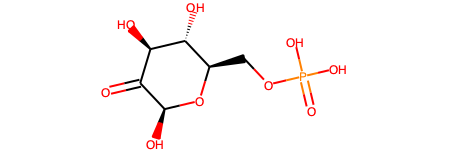

In [137]:
Chem.MolFromSmiles(a[0]["Products"][0])

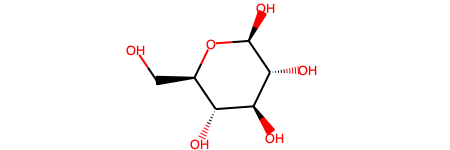

In [139]:
Chem.MolFromSmiles(glucose)

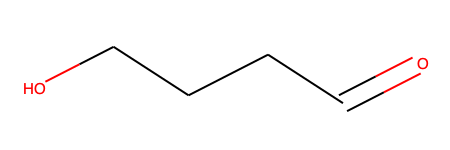

In [107]:
Chem.MolFromSmiles(Smiles4Hydroxybutyraldehyde)

In [95]:
Chem.MolFromSmiles(SmilesSuccinylSemialdehyde) == Chem.MolFromSmiles("O=C(O)/C=C\CO")

False

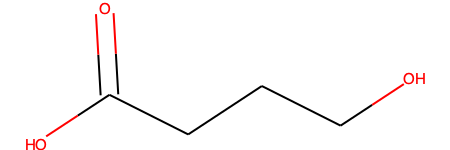

In [100]:
Chem.MolFromSmiles(Smiles4Hydroxybutyrate)

In [140]:
a[0]["Products"][0]

'O=C1[C@@H](O)[C@H](O)[C@@H](COP(=O)(O)O)O[C@H]1O'